## Setup

In [1]:
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms, datasets
from multiprocessing import cpu_count
from collections import OrderedDict
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch
import olympic

import sys
from typing import Union, Callable, Tuple
from functional import boundary, iterated_fgsm, local_search, pgd

if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

from livelossplot import PlotLosses

# Training an MNIST classifier

In [5]:
transform = transforms.Compose([transforms.ToTensor(),])

train = datasets.MNIST('../data/', train=True, transform=transform, download=True)
val = datasets.MNIST('../data/', train=False, transform=transform, download=True)

train_loader = DataLoader(train, batch_size=128, num_workers=cpu_count())
val_loader = DataLoader(val, batch_size=128, num_workers=cpu_count())

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(1024, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 1024)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train_model(model, criterion, optimizer, num_epochs=10):
    liveloss = PlotLosses()
    model = model.to(device)
    
    for epoch in range(num_epochs):
        logs = {}
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.float() / len(dataloaders[phase].dataset)
            
            prefix = ''
            if phase == 'validation':
                prefix = 'val_'

            logs[prefix + 'log loss'] = epoch_loss.item()
            logs[prefix + 'accuracy'] = epoch_acc.item()
        
        liveloss.update(logs)
        liveloss.send()

In [14]:
model = Net().to(DEVICE)
optimiser = optim.SGD(model.parameters(), lr=0.1)
loss_fn = nn.CrossEntropyLoss()

criterion = loss_fn
optimizer = optimiser

dataloaders = {
    "train": train_loader,
    "validation": val_loader
}

#train_model(model, criterion, optimizer, num_epochs=20)

In [42]:
history_natural = olympic.fit(
    model,
    optimiser,
    loss_fn,
    dataloader=train_loader,
    epochs=10,
    metrics=['accuracy'],
    prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)),
    callbacks=[
        olympic.callbacks.Evaluate(val_loader),
        olympic.callbacks.ReduceLROnPlateau(patience=5)
    ]
)

Epoch 10: 100%|██████████| 469/469 [01:48<00:00,  4.33it/s, loss=0.0261, accuracy=0.993, val_loss=0.0375, val_accuracy=0.987]Finished.



In [43]:
torch.save(model, 'mnist_model.pt')

In [17]:
olympic.evaluate(model, val_loader, metrics=['accuracy'],
                 prepare_batch = lambda batch: (batch[0].to(DEVICE), batch[1].to(DEVICE)))

{'val_accuracy': 0.9866}

In [ ]:
model = torch.load('mnist_model.pt',map_location=torch.device('cpu')).to(DEVICE)

# Visualization

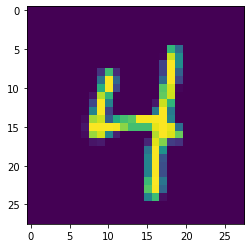

In [11]:
plt.imshow(val[19][0][0])

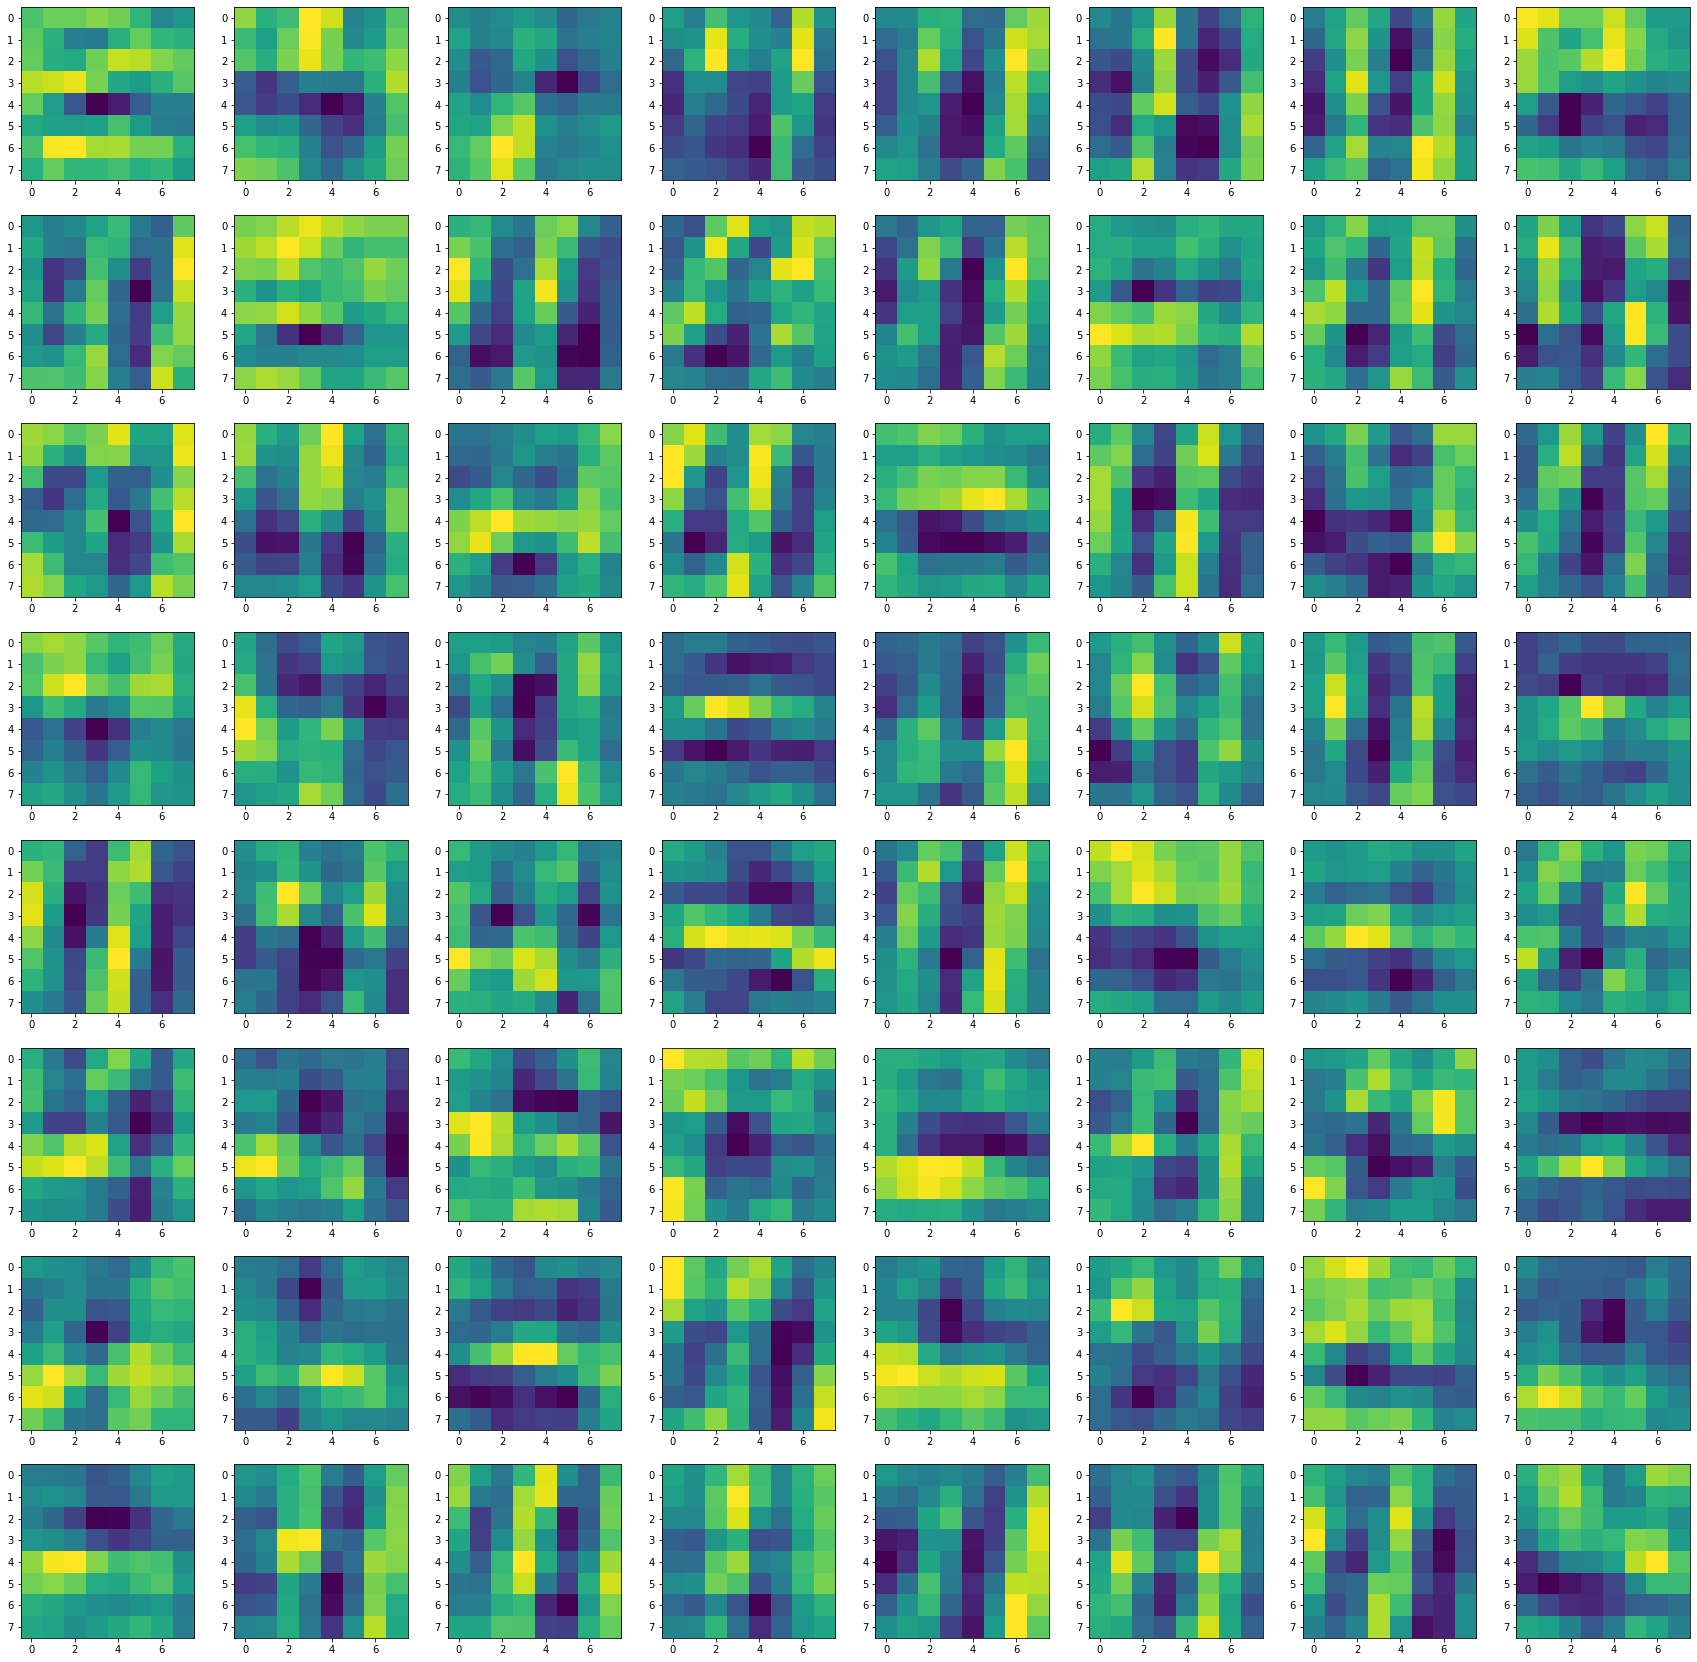

In [21]:
# Visualize feature maps of Conv2
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv2.register_forward_hook(get_activation('conv2'))
x,y = val[19]
x=x.unsqueeze(0).to(DEVICE)
output = model(x) 

act = activation['conv2'].squeeze()
fig, axarr = plt.subplots(8,8,figsize=(30,30))
idx=0
for i in range(8):
    for j in range(8):
        axarr[i,j].imshow(act[idx])
        idx+=1


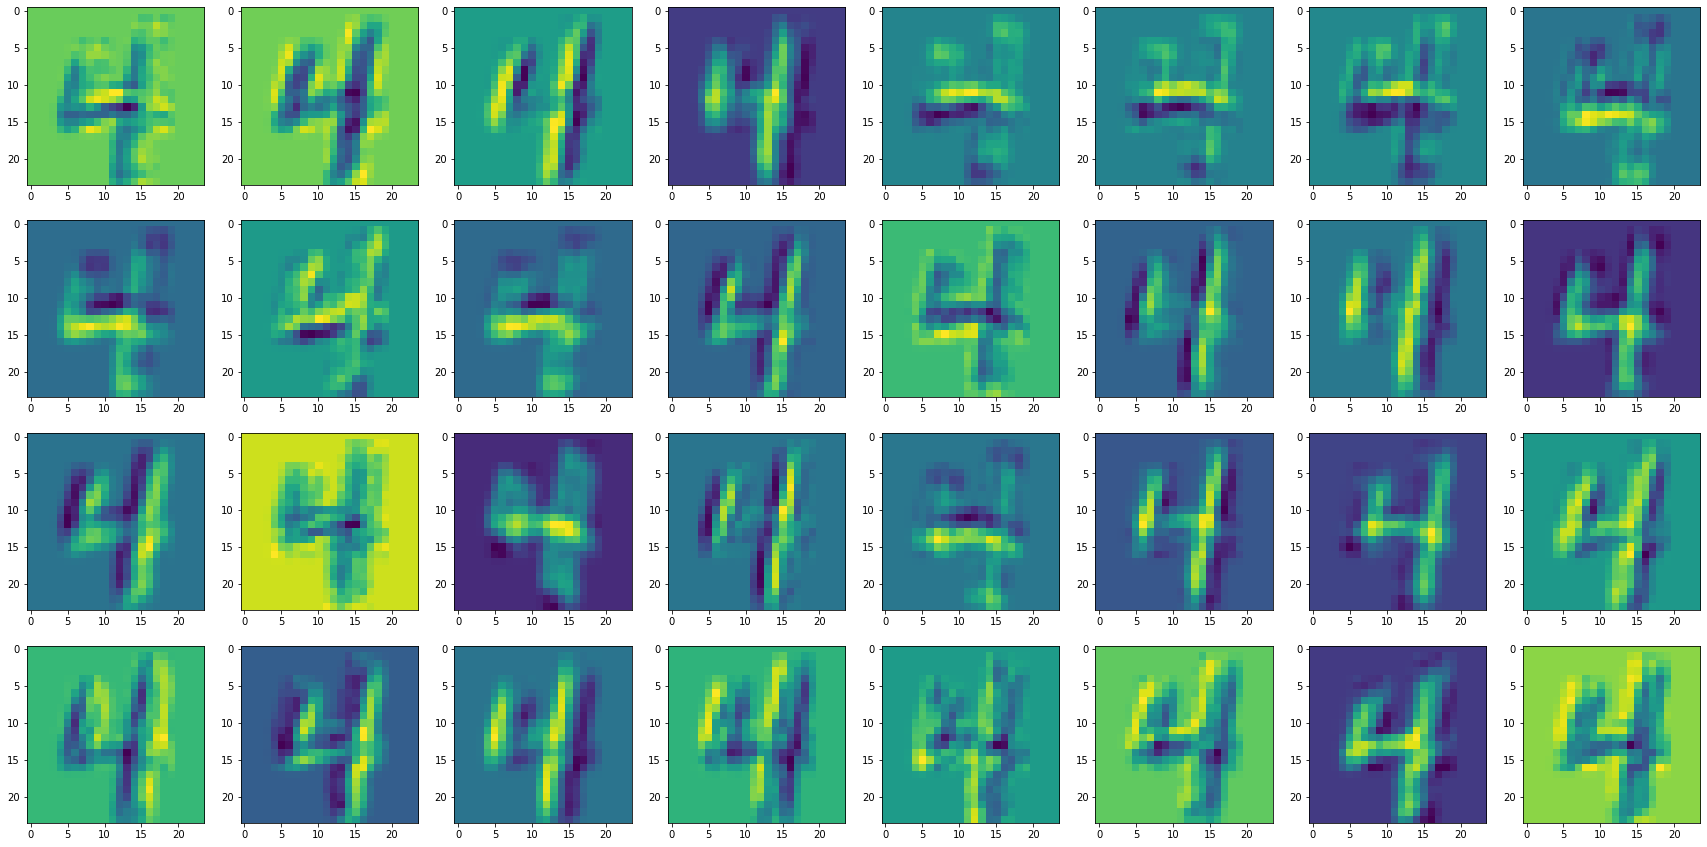

In [15]:
# Visualize feature maps of Conv1
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))
x,y = val[19]
x=x.unsqueeze(0).to(DEVICE)
output = model(x) 

act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(4,8,figsize=(30,15))
idx=0
for i in range(4):
    for j in range(8):
        axarr[i,j].imshow(act[idx])
        idx+=1

In [145]:
kernels[0].squeeze().numpy().mean()

0.037732802

(array([ 4.,  3., 10.,  3.,  3.,  2.,  1.,  1.,  2.,  3.]),
 array([-0.0779011 , -0.0533503 , -0.02879949, -0.00424869,  0.02030212,
         0.04485292,  0.06940373,  0.09395453,  0.11850534,  0.14305614,
         0.16760695], dtype=float32),
 <a list of 10 Patch objects>)

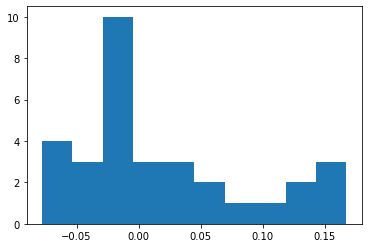

In [154]:
mean_act = [np.median((model.conv1.weight.detach())[i].squeeze().numpy()) for i in range(32)]
plt.hist(mean_act)

(array([ 1.,  0.,  0.,  2.,  1.,  4.,  4.,  1.,  0., 19.]),
 array([-0.09418109, -0.08475231, -0.07532354, -0.06589476, -0.05646598,
        -0.04703721, -0.03760843, -0.02817966, -0.01875088, -0.0093221 ,
         0.00010667], dtype=float32),
 <a list of 10 Patch objects>)

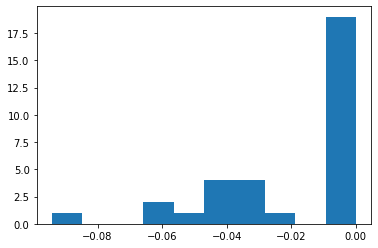

In [156]:
mean_act = [np.median((adv_model_linf.conv1.weight.detach())[i].squeeze().numpy()) for i in range(32)]
plt.hist(mean_act)

(array([ 1.,  0.,  0.,  2.,  2.,  5.,  4., 11.,  4.,  3.]),
 array([-0.1363718 , -0.11865121, -0.10093062, -0.08321002, -0.06548943,
        -0.04776883, -0.03004823, -0.01232764,  0.00539296,  0.02311356,
         0.04083415], dtype=float32),
 <a list of 10 Patch objects>)

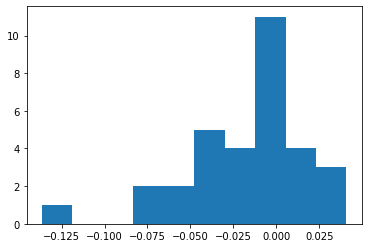

In [157]:
mean_act = [np.median((adv_model_l2.conv1.weight.detach())[i].squeeze().numpy()) for i in range(32)]
plt.hist(mean_act)

In [28]:
model.conv2.weight.detach().shape

torch.Size([64, 32, 5, 5])

In [20]:
model.conv1.weight.detach().shape

torch.Size([32, 1, 5, 5])

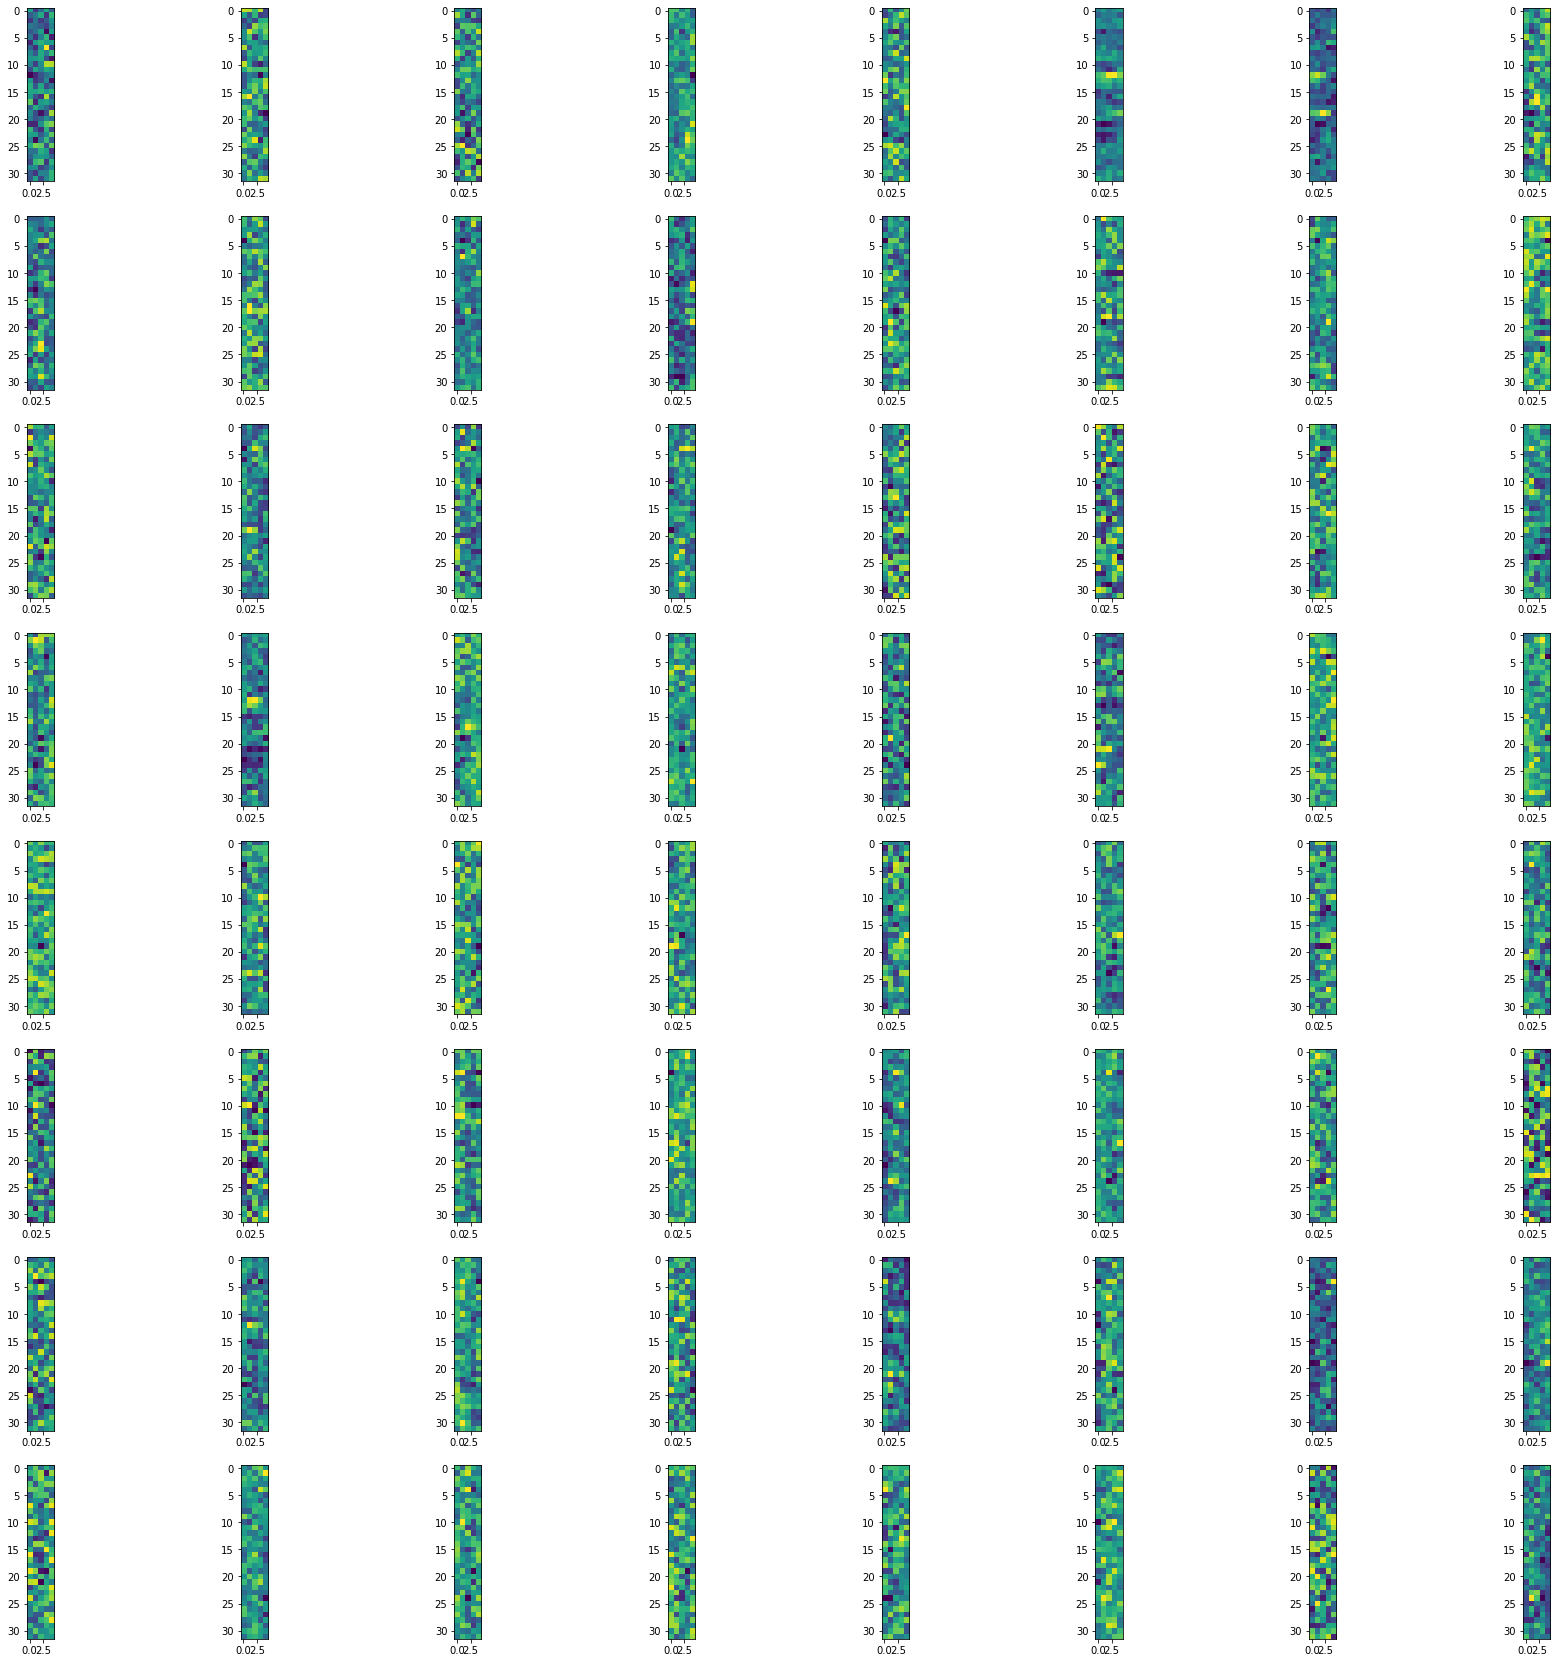

In [27]:
# Visualize conv filter of Conv1
kernels2 = model.conv2.weight.detach()[:,:,:,0]
fig, axarr = plt.subplots(8,8,figsize=(30,30))
idx=0
for i in range(8):
    for j in range(8):
        axarr[i,j].imshow(kernels2[idx].squeeze())
        idx+=1

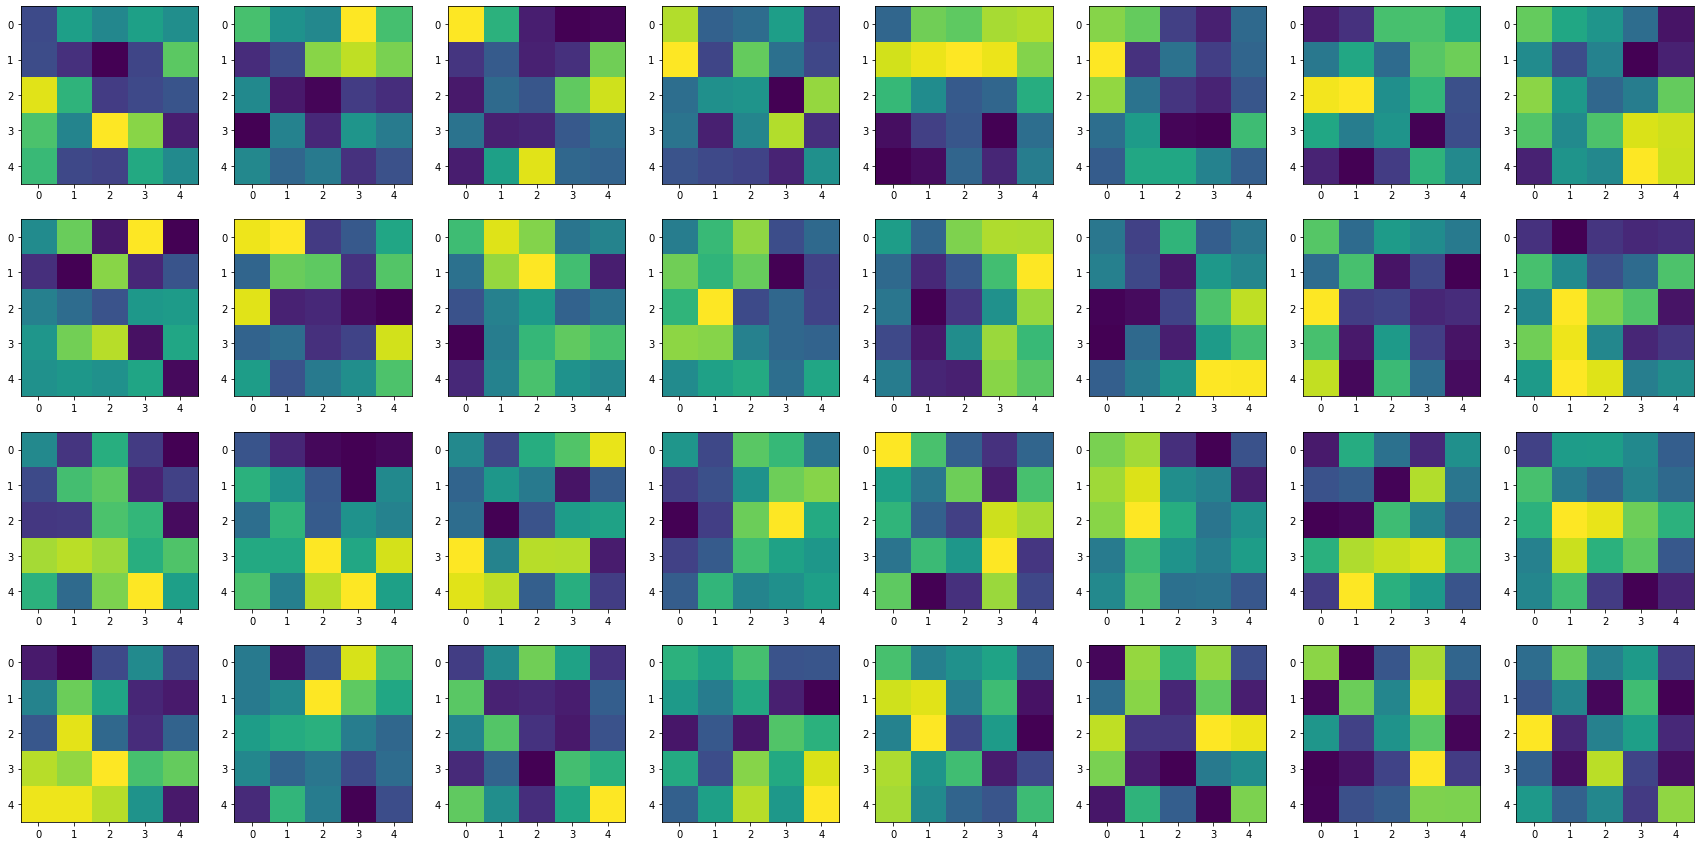

In [15]:
# Visualize conv filter of Conv1
kernels = model.conv1.weight.detach()
fig, axarr = plt.subplots(4,8,figsize=(30,15))
idx=0
for i in range(4):
    for j in range(8):
        axarr[i,j].imshow(kernels[idx].squeeze())
        idx+=1

# Iterative adversarial attacks

In [14]:
def visualise_adversarial_examples(model, x, y, l2_eps=2, linf_eps=0.15):
    x = x.unsqueeze(0).to(DEVICE)
    y=torch.tensor(y)
    y = y.unsqueeze(0).to(DEVICE)
    x_adv_l2 = pgd(model, x, y, torch.nn.CrossEntropyLoss(), k=120, step=0.1, eps=l2_eps, norm=2)
    x_adv_linf = iterated_fgsm(model, x, y, torch.nn.CrossEntropyLoss(), k=60, step=0.01, eps=linf_eps, norm='inf')
    

    y_pred = model(x)
    y_pred_l2 = model(x_adv_l2)
    y_pred_linf = model(x_adv_linf)
    
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    
    axes[0].imshow(x[0, 0].cpu().numpy(), cmap='gray')
    axes[0].set_title(
        f'Original sample, '
        f'P({ y_pred.argmax(dim=1).item()}) = '
        f'{np.round(y_pred.softmax(dim=1)[0, y_pred.argmax(dim=1).item()].item(), 3)}')
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    
    axes[1].imshow(x_adv_l2[0, 0].cpu().numpy(), cmap='gray')
    axes[1].set_title(
        f'$L^2$ PGD adversary, '
        f'eps={l2_eps}, '
        f'P({y_pred_l2.argmax(dim=1).item()}) = '
        f'{np.round(y_pred_l2.softmax(dim=1)[0, y_pred_l2.argmax(dim=1).item()].item(), 3)}')
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    
    axes[2].imshow(x_adv_linf[0, 0].cpu().numpy(), cmap='gray')
    axes[2].set_title(
        '$L^{\infty}$ FGSM adversary, '
        f'eps={linf_eps}, '
        f'P({y_pred_linf.argmax(dim=1).item()}) = '
        f'{np.round(y_pred_linf.softmax(dim=1)[0, y_pred_linf.argmax(dim=1).item()].item(), 3)}')
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    
    
    plt.show()

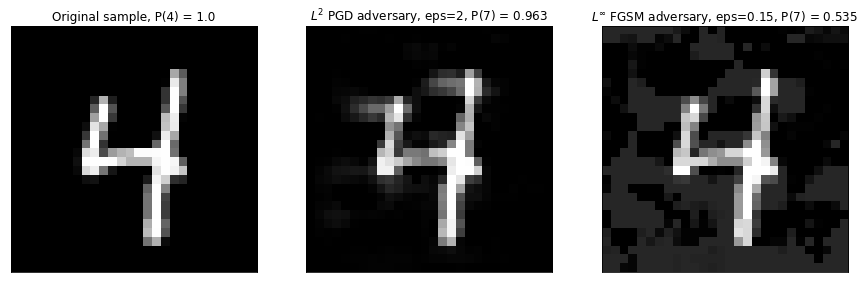

In [15]:
visualise_adversarial_examples(model, *val[19])

# MSE Similarity Study

In [16]:
def mse(imageA, imageB):
	err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
	err /= float(imageA.shape[0] * imageA.shape[1])
	return err

0.13326562965766928

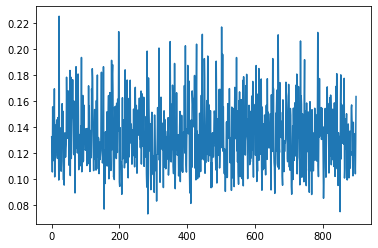

In [70]:
#Similarity of the digit 5 in val[15] with 800 of other classes

Lmse=[]
i=0
A=val[15][0][0].numpy()
while(len(Lmse)<900):
    if (val[i][1]!=5):
        B=val[i][0][0].numpy()
        e=mse(A,B)
        Lmse+=[e]
    i+=1
plt.plot(Lmse)
np.mean(Lmse)

0.12990419714151274

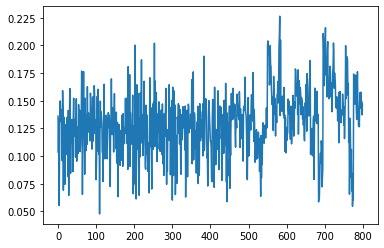

In [69]:
#Similarity of the digit 5 in val[15] with 800 of the same class

Lmse=[]
i=16
A=val[15][0][0].numpy()
while(len(Lmse)<800):
    if (val[i][1]==5):
        B=val[i][0][0].numpy()
        e=mse(A,B)
        Lmse+=[e]
    i+=1
plt.plot(Lmse)
np.mean(Lmse)

In [96]:
x,y = val[15]
x=x.unsqueeze(0).to(DEVICE)
y=torch.tensor(y)
y = y.unsqueeze(0).to(DEVICE)
x_adv_linf = iterated_fgsm(model, x, y, torch.nn.CrossEntropyLoss(), k=60, step=0.01, eps=0.15, norm='inf')
output=model(x_adv_linf)
output.argmax(dim=1).item()

3

0.12630925276437646

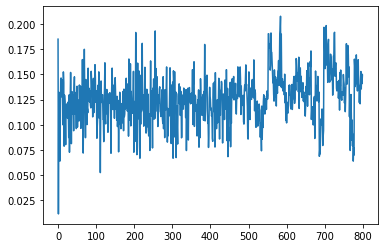

In [97]:
#Similarity of the perturbed digit 5 classified as 3 with 800 of the class 5

x,y = val[15]
x=x.unsqueeze(0).to(DEVICE)
y=torch.tensor(y)
y = y.unsqueeze(0).to(DEVICE)
x_adv_linf = iterated_fgsm(model, x, y, torch.nn.CrossEntropyLoss(), k=60, step=0.01, eps=0.15, norm='inf')
x_adv_l2 = x_adv_linf

Lmse=[]
i=0
A=x_adv_l2[0,0].numpy()
while(len(Lmse)<800):
    if (val[i][1]==5):
        B=val[i][0][0].numpy()
        e=mse(A,B)
        Lmse+=[e]
    i+=1
plt.plot(Lmse)
np.mean(Lmse)

0.11797611593141266

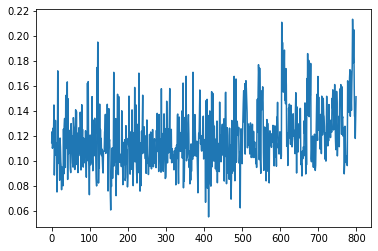

In [98]:
#Similarity of the perturbed digit 5 classified as 3 with 800 of the class 3

x,y = val[15]
x=x.unsqueeze(0).to(DEVICE)
y=torch.tensor(y)
y = y.unsqueeze(0).to(DEVICE)
x_adv_linf = iterated_fgsm(model, x, y, torch.nn.CrossEntropyLoss(), k=60, step=0.01, eps=0.15, norm='inf')
x_adv_l2 = x_adv_linf

Lmse=[]
i=0
A=x_adv_l2[0,0].numpy()
while(len(Lmse)<800):
    if (val[i][1]==3):
        B=val[i][0][0].numpy()
        e=mse(A,B)
        Lmse+=[e]
    i+=1
plt.plot(Lmse)
np.mean(Lmse)

0.1515882887009099

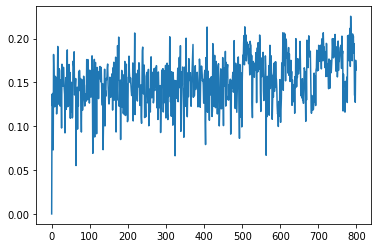

In [99]:
#Similarity of the digit 3 in val[18] with 800 of the same class

Lmse=[]
i=18
A=val[18][0][0].numpy()
while(len(Lmse)<800):
    if (val[i][1]==3):
        B=val[i][0][0].numpy()
        e=mse(A,B)
        Lmse+=[e]
    i+=1
plt.plot(Lmse)
np.mean(Lmse)

In [101]:
x,y = val[15]
x=x.unsqueeze(0).to(DEVICE)
y=torch.tensor(y)
y = y.unsqueeze(0).to(DEVICE)
x_adv_linf = iterated_fgsm(model, x, y, torch.nn.CrossEntropyLoss(), k=60, step=0.01, eps=0.15, norm='inf')

mse(val[18][0][0].numpy(),x_adv_linf[0][0].numpy())

0.11444783606210124

# Visualization

In [18]:
x,y = val[19]
x=x.unsqueeze(0).to(DEVICE)
y=torch.tensor(y)
y = y.unsqueeze(0).to(DEVICE)
x_adv_l2 = pgd(model, x, y, torch.nn.CrossEntropyLoss(), k=120, step=0.1, eps=1.7, norm=2)
x_adv_l2.shape

torch.Size([1, 1, 28, 28])

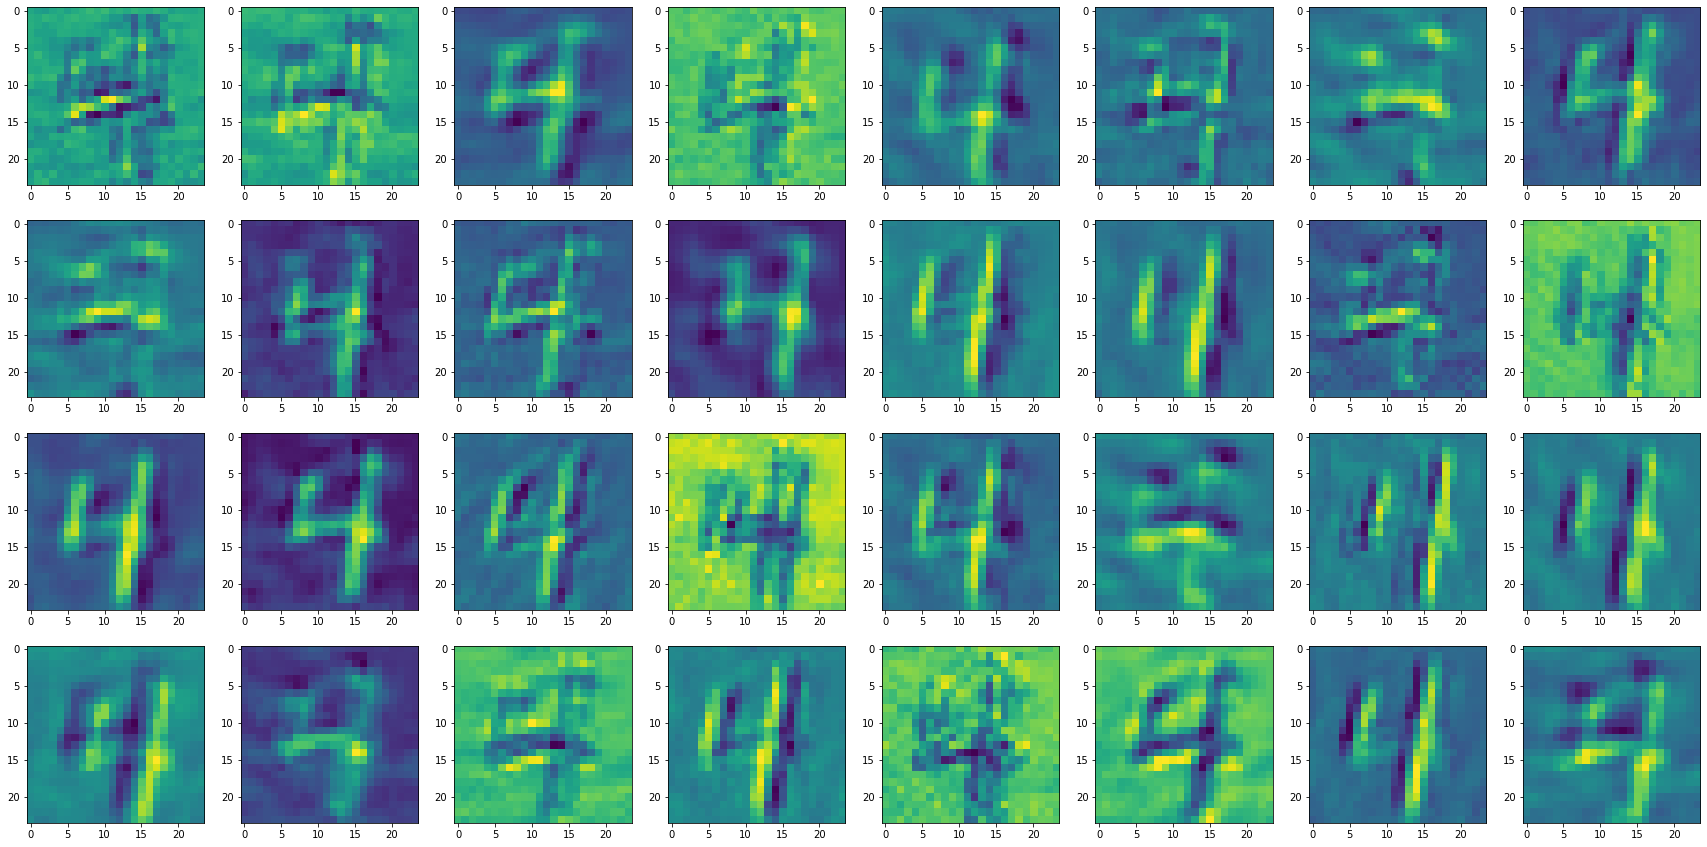

In [19]:
# Visualize feature maps of FGSM sample through 1st conv layer in non robust model
activation_adv = {}
def get_activation(name):
    def hook(model, input, output):
        activation_adv[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))

x,y = val[19]
x=x.unsqueeze(0).to(DEVICE)
y=torch.tensor(y)
y = y.unsqueeze(0).to(DEVICE)
x_adv_linf = iterated_fgsm(model, x, y, torch.nn.CrossEntropyLoss(), k=60, step=0.01, eps=0.15, norm='inf')
output = model(x_adv_linf) 

act_adv = activation_adv['conv1'].squeeze()
fig, axarr = plt.subplots(4,8,figsize=(30,15))
idx=0


for i in range(4):
    for j in range(8):
        axarr[i,j].imshow(act_adv[idx])
        idx+=1

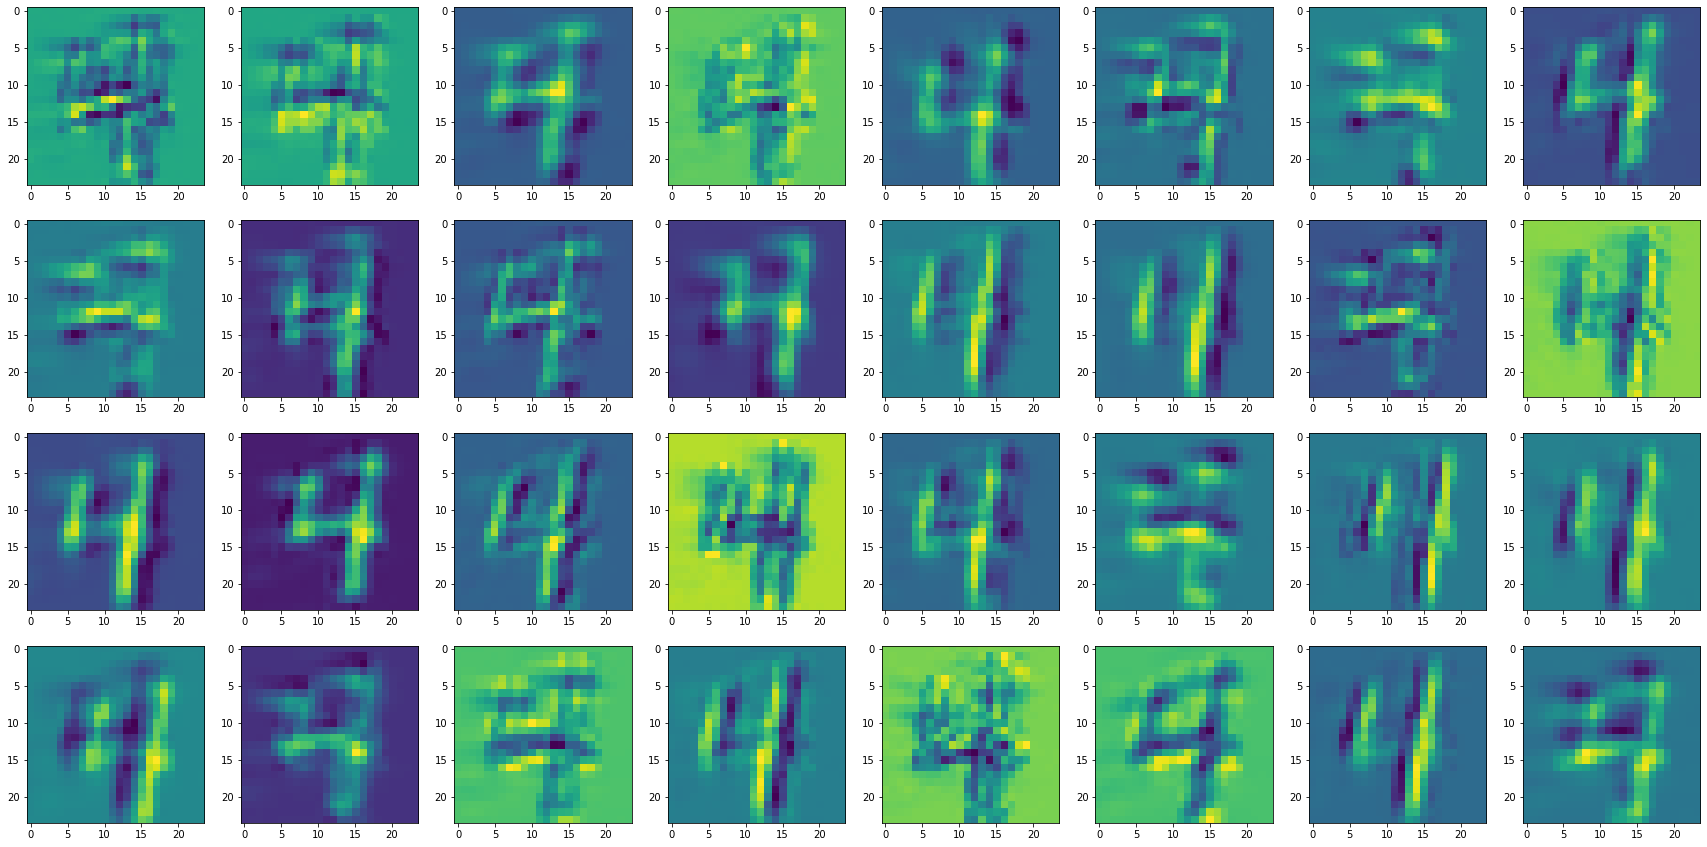

In [20]:
# Visualize feature maps of PGD sample through 1st conv layer in non robust model
activation_adv = {}
def get_activation(name):
    def hook(model, input, output):
        activation_adv[name] = output.detach()
    return hook

model.conv1.register_forward_hook(get_activation('conv1'))

x,y = val[19]
x=x.unsqueeze(0).to(DEVICE)
y=torch.tensor(y)
y = y.unsqueeze(0).to(DEVICE)
x_adv_l2 = pgd(model, x, y, torch.nn.CrossEntropyLoss(), k=120, step=0.1, eps=1.7, norm=2)

output = model(x_adv_l2) 

act_adv = activation_adv['conv1'].squeeze()
fig, axarr = plt.subplots(4,8,figsize=(30,15))
idx=0
for i in range(4):
    for j in range(8):
        axarr[i,j].imshow(act_adv[idx])
        idx+=1

(array([ 5.,  3.,  4., 10.,  3.,  1.,  2.,  1.,  1.,  2.]),
 array([-0.05729784, -0.0320663 , -0.00683476,  0.01839678,  0.04362831,
         0.06885985,  0.09409139,  0.11932293,  0.14455447,  0.169786  ,
         0.19501755], dtype=float32),
 <a list of 10 Patch objects>)

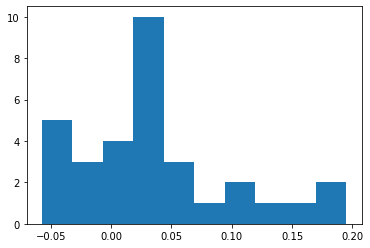

In [185]:
mean= [(act_adv[i]-act[i]).squeeze().numpy().mean() for i in range(32)]
plt.hist(mean)

(array([5., 1., 7., 5., 7., 1., 1., 2., 1., 2.]),
 array([-0.065262  , -0.03726718, -0.00927235,  0.01872247,  0.04671729,
         0.07471212,  0.10270695,  0.13070177,  0.15869659,  0.18669142,
         0.21468624], dtype=float32),
 <a list of 10 Patch objects>)

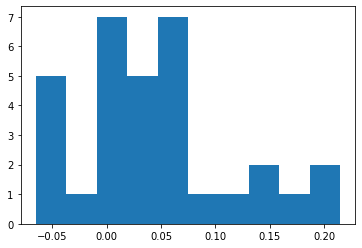

In [186]:
med = [np.median((act_adv[i]-act[i]).squeeze().numpy()) for i in range(32)]
plt.hist(med)

(array([11.,  6.,  9.,  0.,  1.,  2.,  1.,  0.,  0.,  2.]),
 array([0.00250116, 0.00958774, 0.01667433, 0.02376092, 0.03084751,
        0.03793409, 0.04502068, 0.05210727, 0.05919385, 0.06628044,
        0.07336703], dtype=float32),
 <a list of 10 Patch objects>)

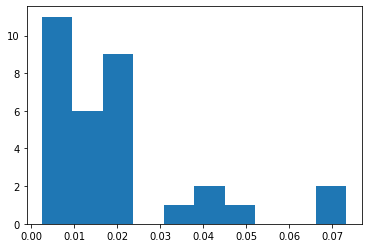

In [196]:
mean= [(act_adv[i]-act[i]).squeeze().numpy().var() for i in range(32)]
plt.hist(mean)

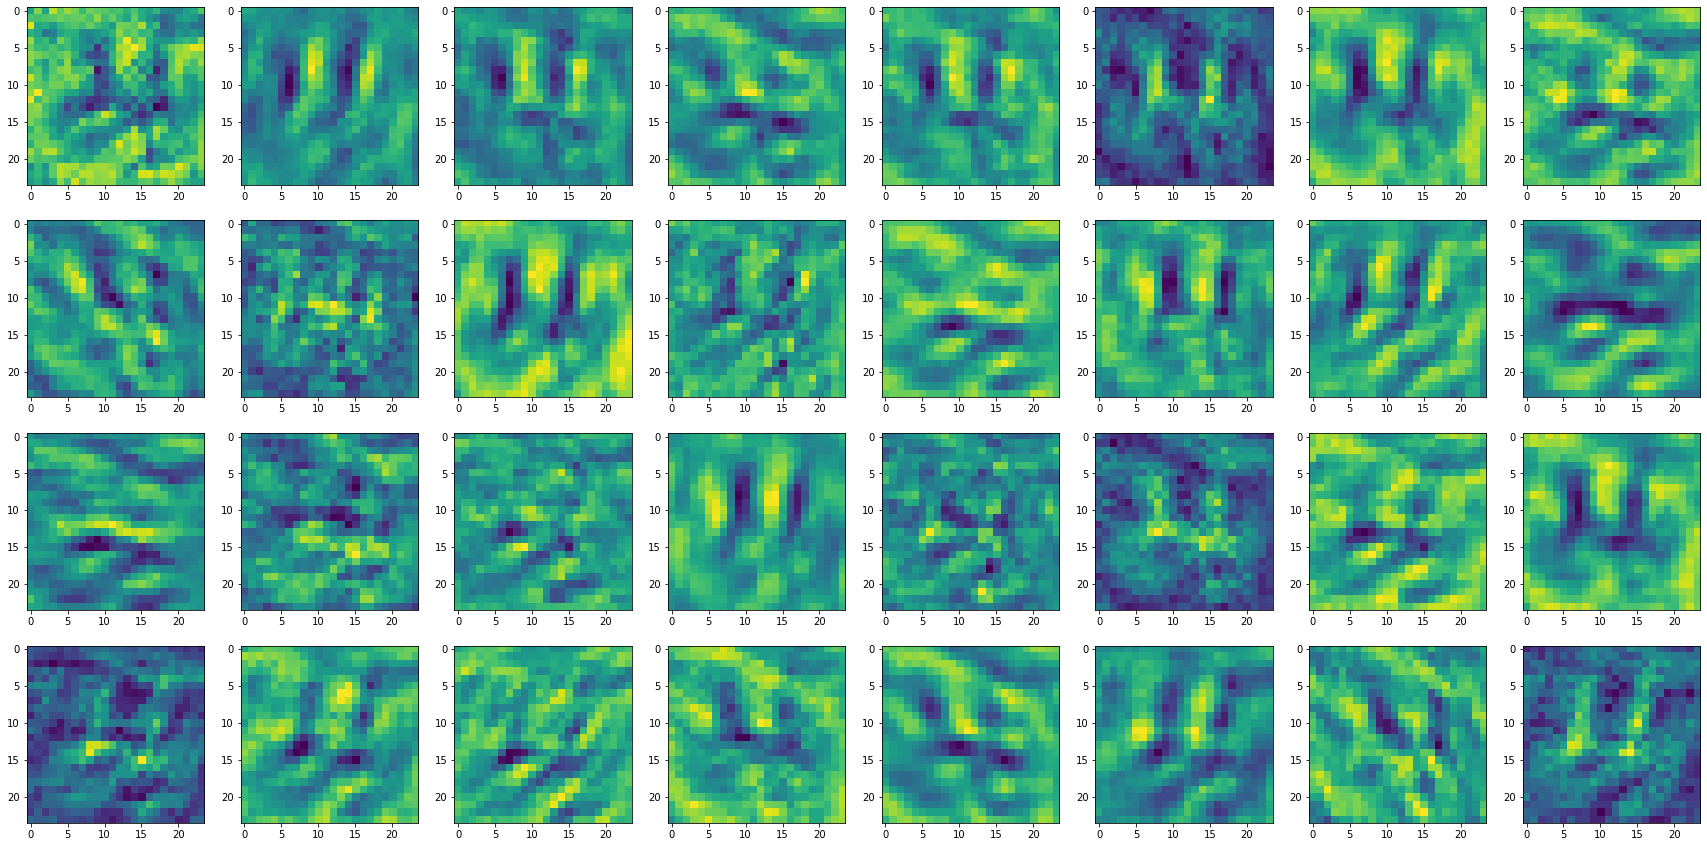

In [195]:
# Difference Original-FGSM
fig, axarr = plt.subplots(4,8,figsize=(30,15))
idx=0
for i in range(4):
    for j in range(8):
        axarr[i,j].imshow(act_adv[idx]-act[idx])
        idx+=1

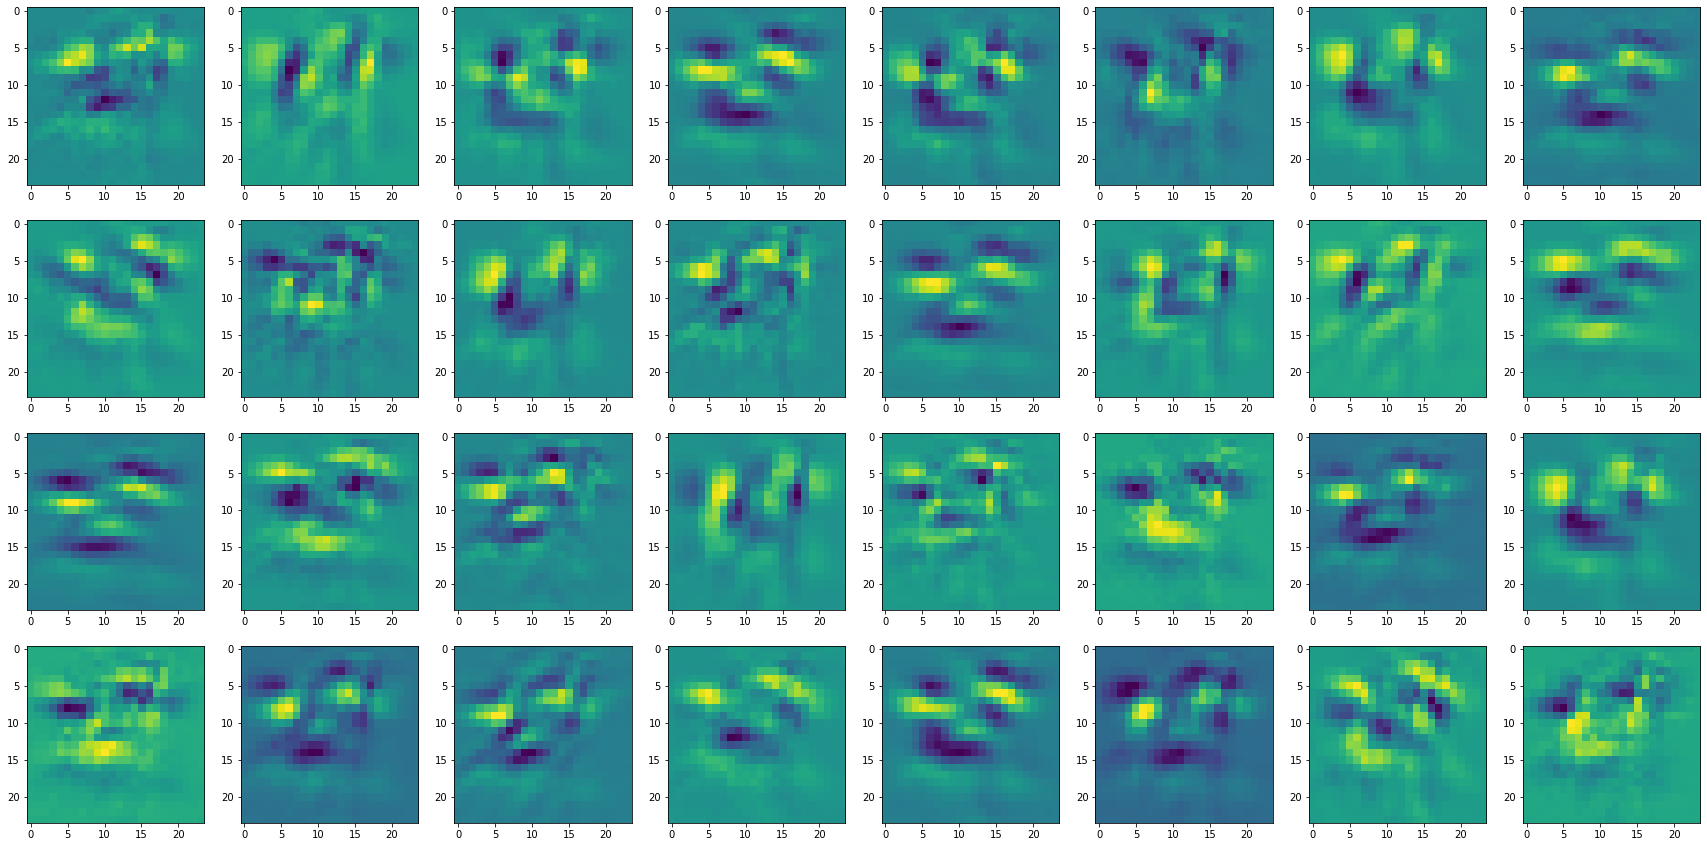

In [188]:
# Difference Original-pgd
fig, axarr = plt.subplots(4,8,figsize=(30,15))
idx=0
for i in range(4):
    for j in range(8):
        axarr[i,j].imshow(act_adv[idx]-act[idx])
        idx+=1

(array([5., 2., 7., 8., 3., 1., 2., 1., 1., 2.]),
 array([-0.01148521, -0.00645544, -0.00142567,  0.0036041 ,  0.00863388,
         0.01366365,  0.01869342,  0.02372319,  0.02875296,  0.03378273,
         0.0388125 ], dtype=float32),
 <a list of 10 Patch objects>)

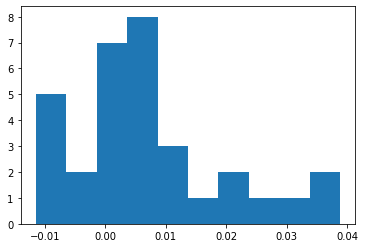

In [189]:
mean= [(act_adv[i]-act[i]).squeeze().numpy().mean() for i in range(32)]
plt.hist(mean)

(array([15.,  8.,  5.,  2.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([0.00123244, 0.00703471, 0.01283698, 0.01863925, 0.02444153,
        0.0302438 , 0.03604607, 0.04184834, 0.04765061, 0.05345289,
        0.05925516], dtype=float32),
 <a list of 10 Patch objects>)

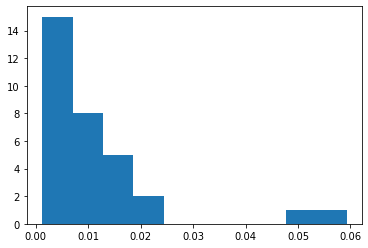

In [192]:
mean= [(act_adv[i]-act[i]).squeeze().numpy().var() for i in range(32)]
plt.hist(mean)

(array([ 5.,  1., 12.,  5.,  3.,  1.,  2.,  1.,  1.,  1.]),
 array([-0.0056885 , -0.00317601, -0.00066351,  0.00184898,  0.00436147,
         0.00687397,  0.00938646,  0.01189896,  0.01441145,  0.01692395,
         0.01943644], dtype=float32),
 <a list of 10 Patch objects>)

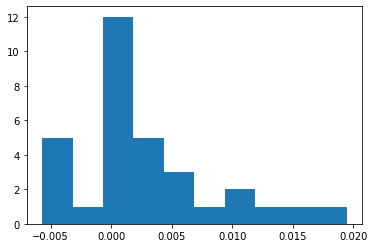

In [190]:
med = [np.median((act_adv[i]-act[i]).squeeze().numpy()) for i in range(32)]
plt.hist(med)

adversarially trained models:

In [18]:
adv_model_linf = torch.load('mnist_fgsm.pt',map_location=torch.device('cpu')).to(DEVICE)

adv_model_l2 = torch.load('mnist_pgd.pt',map_location=torch.device('cpu')).to(DEVICE)

# Visualization

# PGD

(array([5., 5., 4., 5., 1., 4., 4., 2., 0., 2.]),
 array([3.5707093e-05, 2.5371131e-03, 5.0385194e-03, 7.5399256e-03,
        1.0041332e-02, 1.2542738e-02, 1.5044143e-02, 1.7545549e-02,
        2.0046957e-02, 2.2548363e-02, 2.5049768e-02], dtype=float32),
 <a list of 10 Patch objects>)

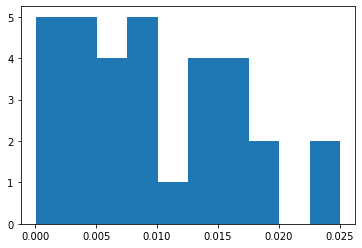

In [199]:
plt.hist([adv_model_l2.conv1.weight.detach()[i].numpy().var() for i in range(32)])

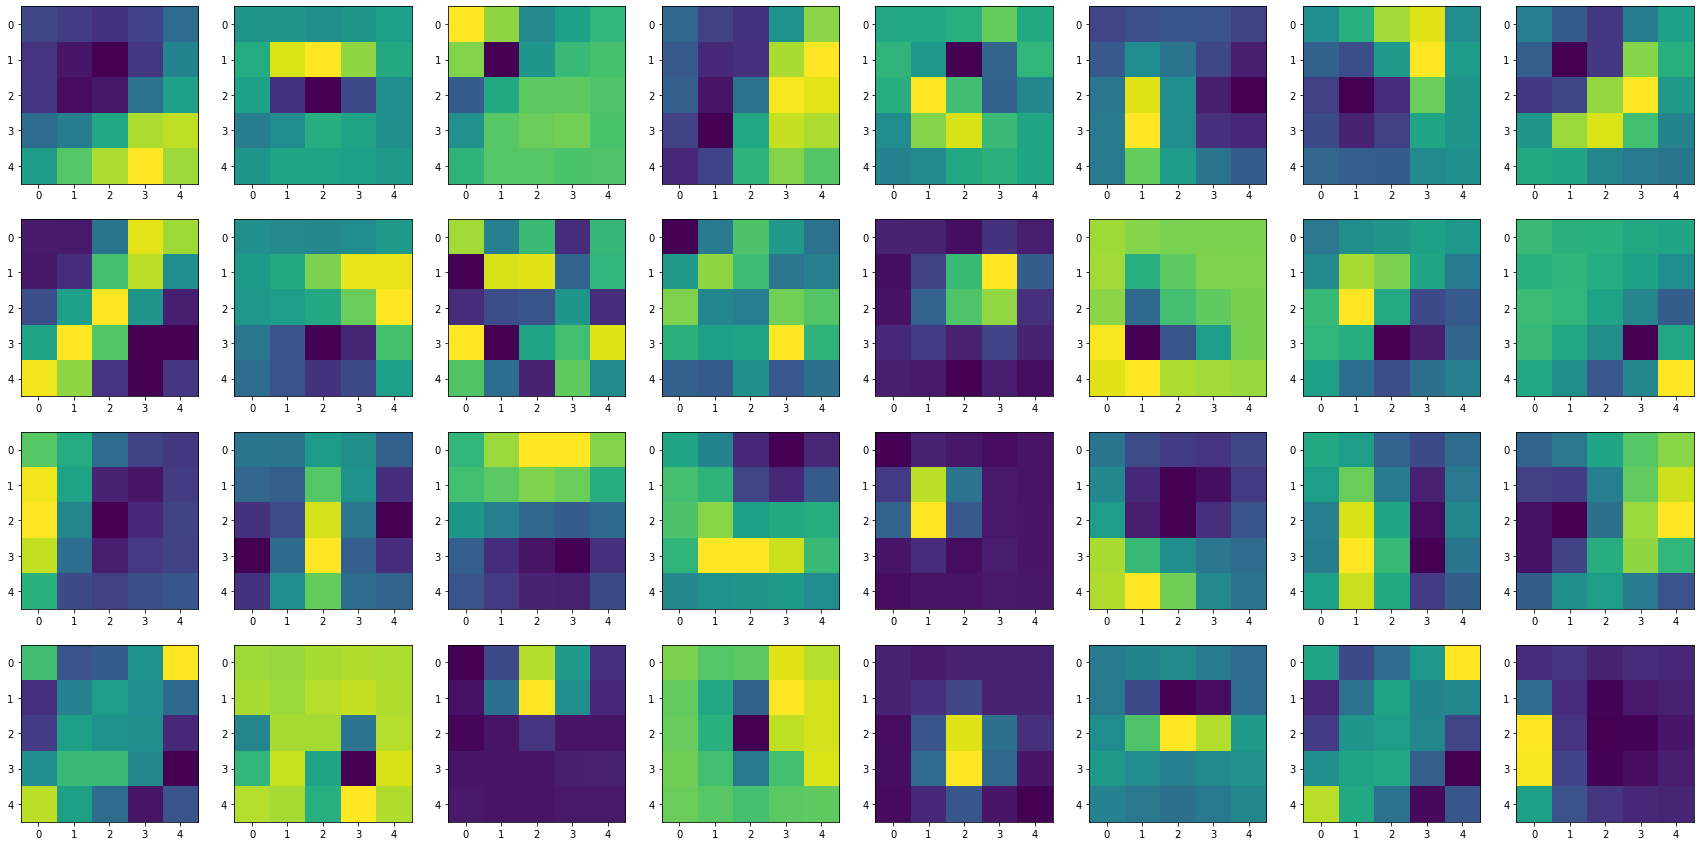

In [19]:
# Visualize conv filter of Conv1
kernels = adv_model_l2.conv1.weight.detach()
fig, axarr = plt.subplots(4,8,figsize=(30,15))
idx=0
for i in range(4):
    for j in range(8):
        axarr[i,j].imshow(kernels[idx].squeeze())
        idx+=1

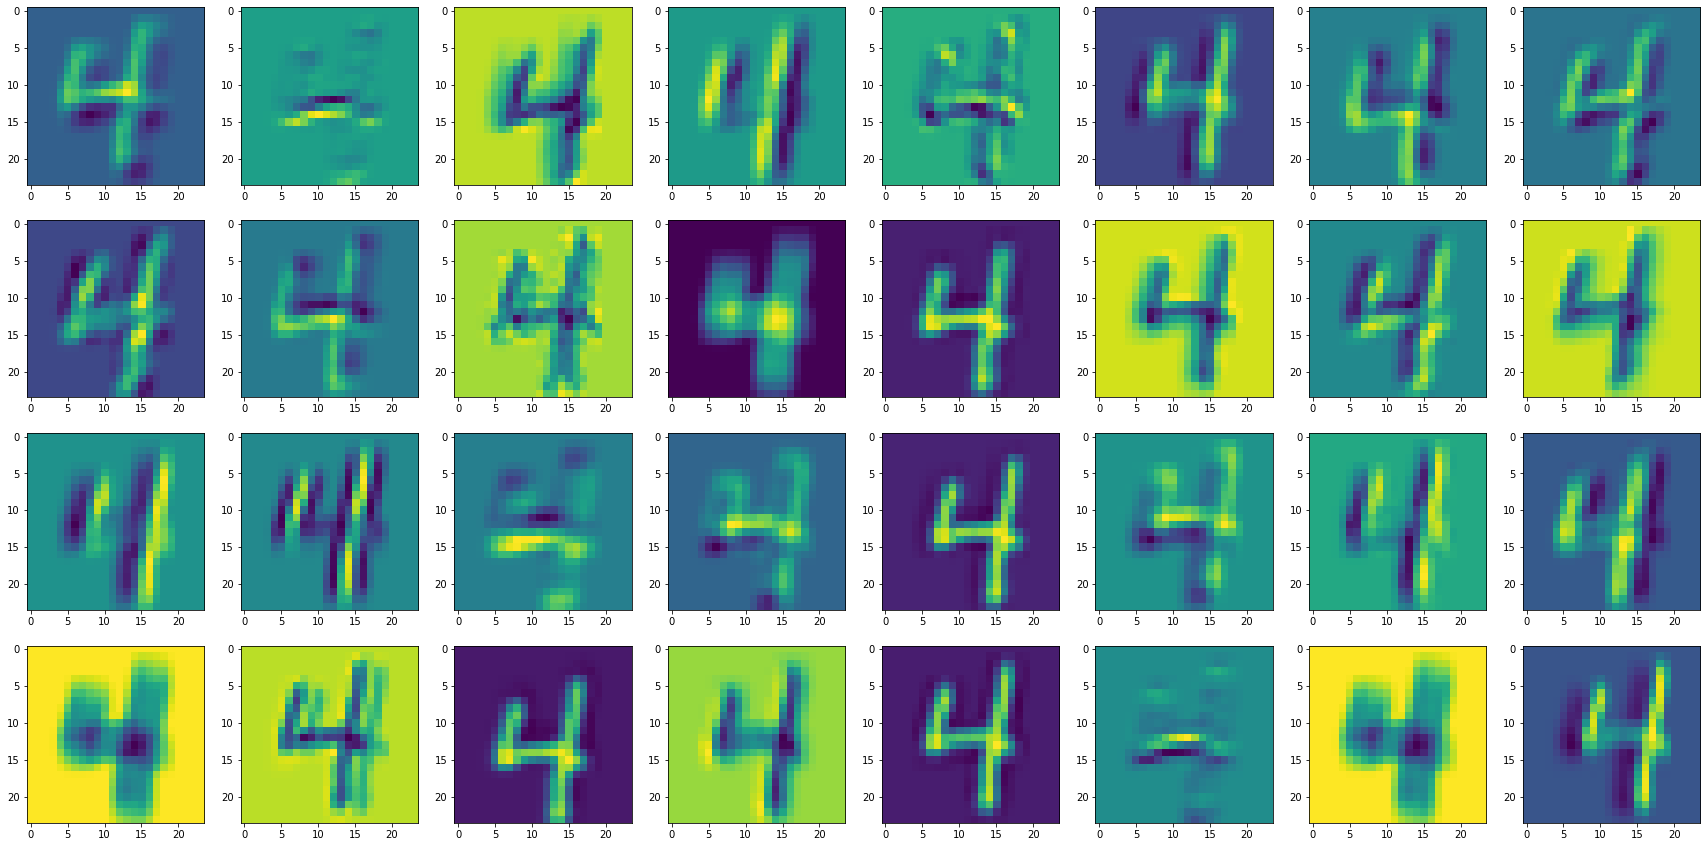

In [123]:
# Visualize feature maps Original Data
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

adv_model_l2.conv1.register_forward_hook(get_activation('conv1'))

x,y = val[19]
x=x.unsqueeze(0).to(DEVICE)
output = adv_model_l2(x) 

act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(4,8,figsize=(30,15))
idx=0
for i in range(4):
    for j in range(8):
        axarr[i,j].imshow(act[idx])
        idx+=1

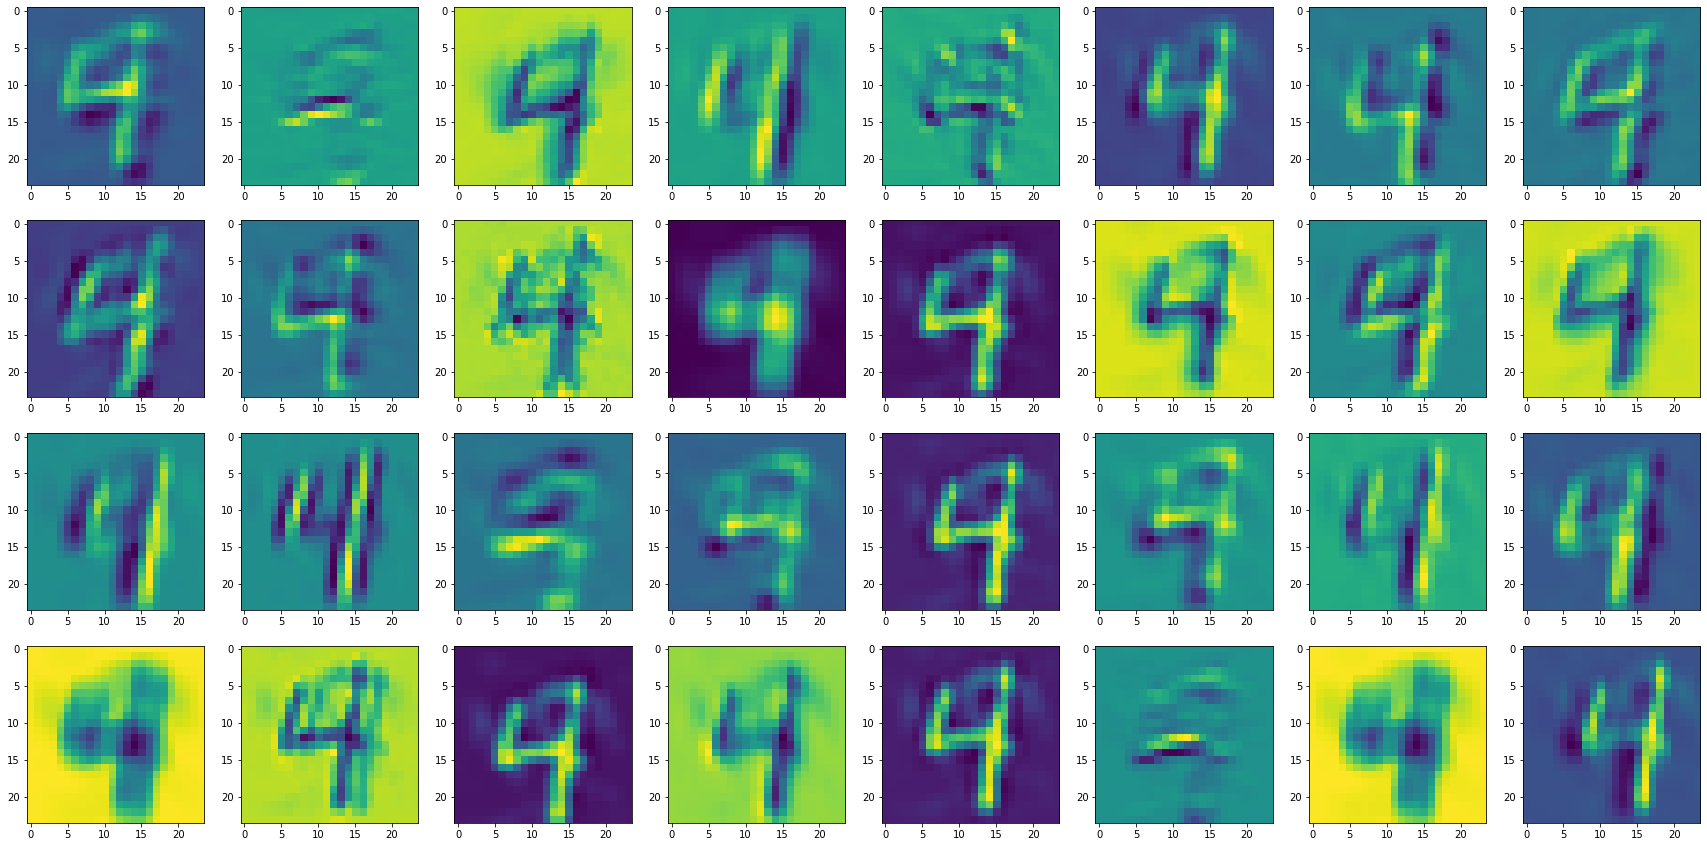

In [19]:
# Visualize feature maps PGD Data
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

adv_model_l2.conv1.register_forward_hook(get_activation('conv1'))

x,y = val[19]
x=x.unsqueeze(0).to(DEVICE)
y=torch.tensor(y)
y = y.unsqueeze(0).to(DEVICE)
x_adv_l2 = pgd(model, x, y, torch.nn.CrossEntropyLoss(), k=120, step=0.1, eps=1.7, norm=2)

output = adv_model_l2(x_adv_l2) 

adv_act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(4,8,figsize=(30,15))
idx=0
for i in range(4):
    for j in range(8):
        axarr[i,j].imshow(adv_act[idx])
        idx+=1

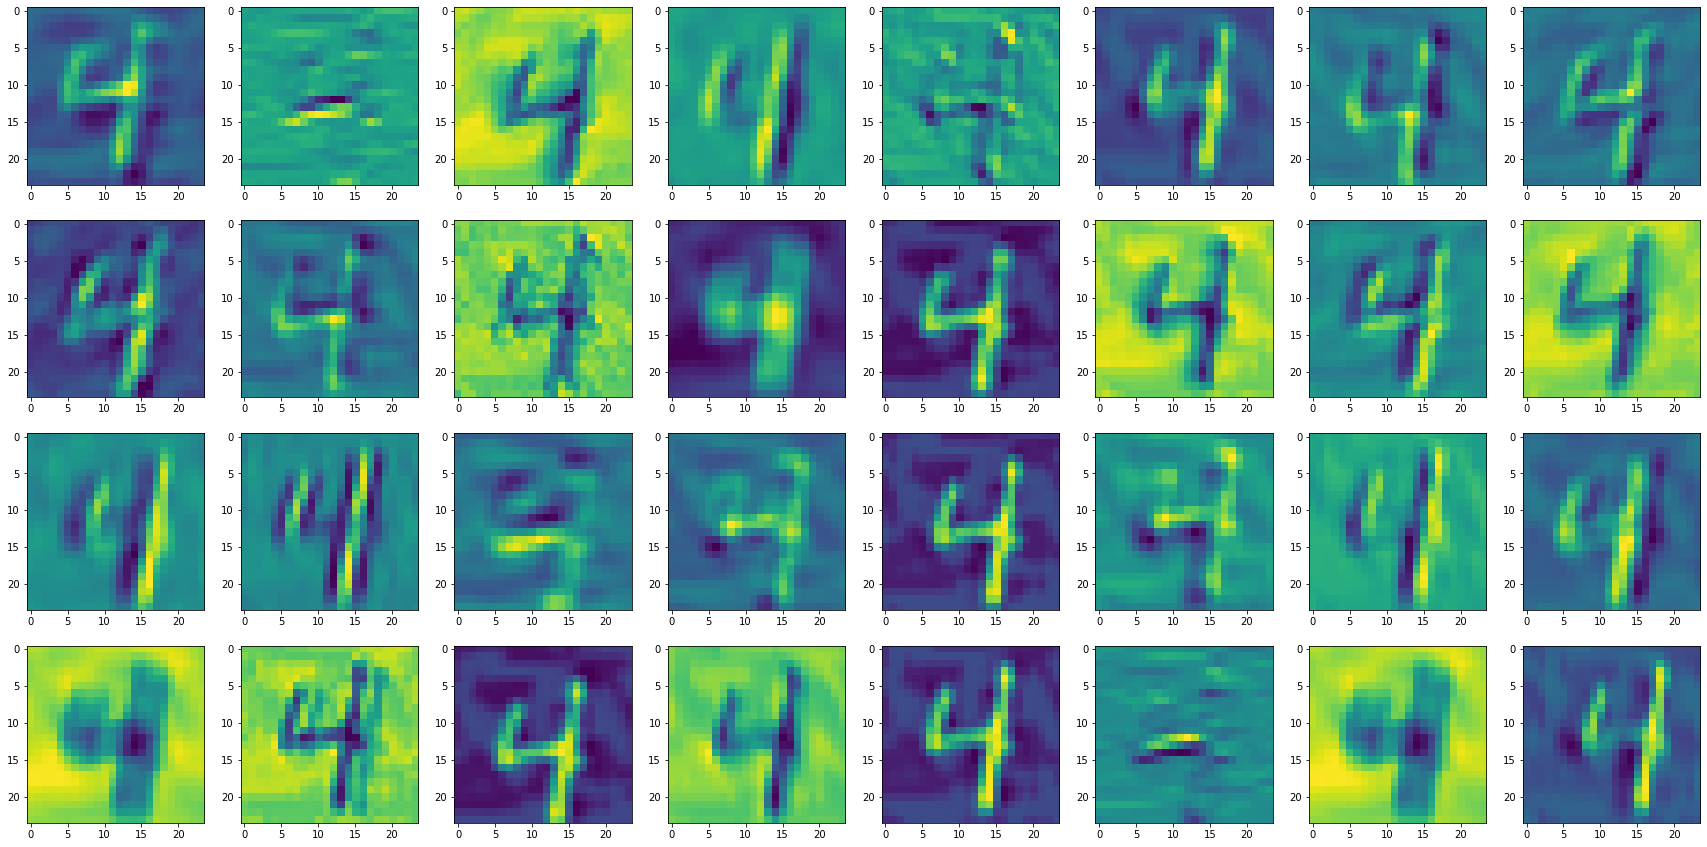

In [20]:
# Visualize feature maps FGSM Data
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

adv_model_l2.conv1.register_forward_hook(get_activation('conv1'))

x,y = val[19]
x=x.unsqueeze(0).to(DEVICE)
y=torch.tensor(y)
y = y.unsqueeze(0).to(DEVICE)
x_adv_linf = iterated_fgsm(model, x, y, torch.nn.CrossEntropyLoss(), k=60, step=0.01, eps=0.15, norm='inf')
output = adv_model_l2(x_adv_linf) 

adv_act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(4,8,figsize=(30,15))
idx=0
for i in range(4):
    for j in range(8):
        axarr[i,j].imshow(adv_act[idx])
        idx+=1

# fgsm

In [201]:
adv_model_linf.conv1.weight.detach()[1].numpy().var()

0.0077221612

(array([25.,  0.,  1.,  1.,  2.,  1.,  0.,  0.,  1.,  1.]),
 array([6.7835648e-10, 5.5914398e-02, 1.1182879e-01, 1.6774319e-01,
        2.2365758e-01, 2.7957198e-01, 3.3548638e-01, 3.9140078e-01,
        4.4731516e-01, 5.0322956e-01, 5.5914396e-01], dtype=float32),
 <a list of 10 Patch objects>)

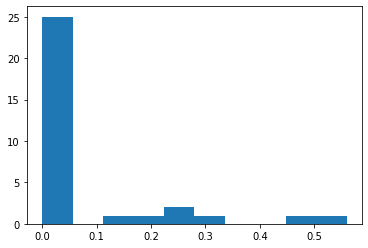

In [198]:
plt.hist([adv_model_linf.conv1.weight.detach()[i].numpy().var() for i in range(32)])

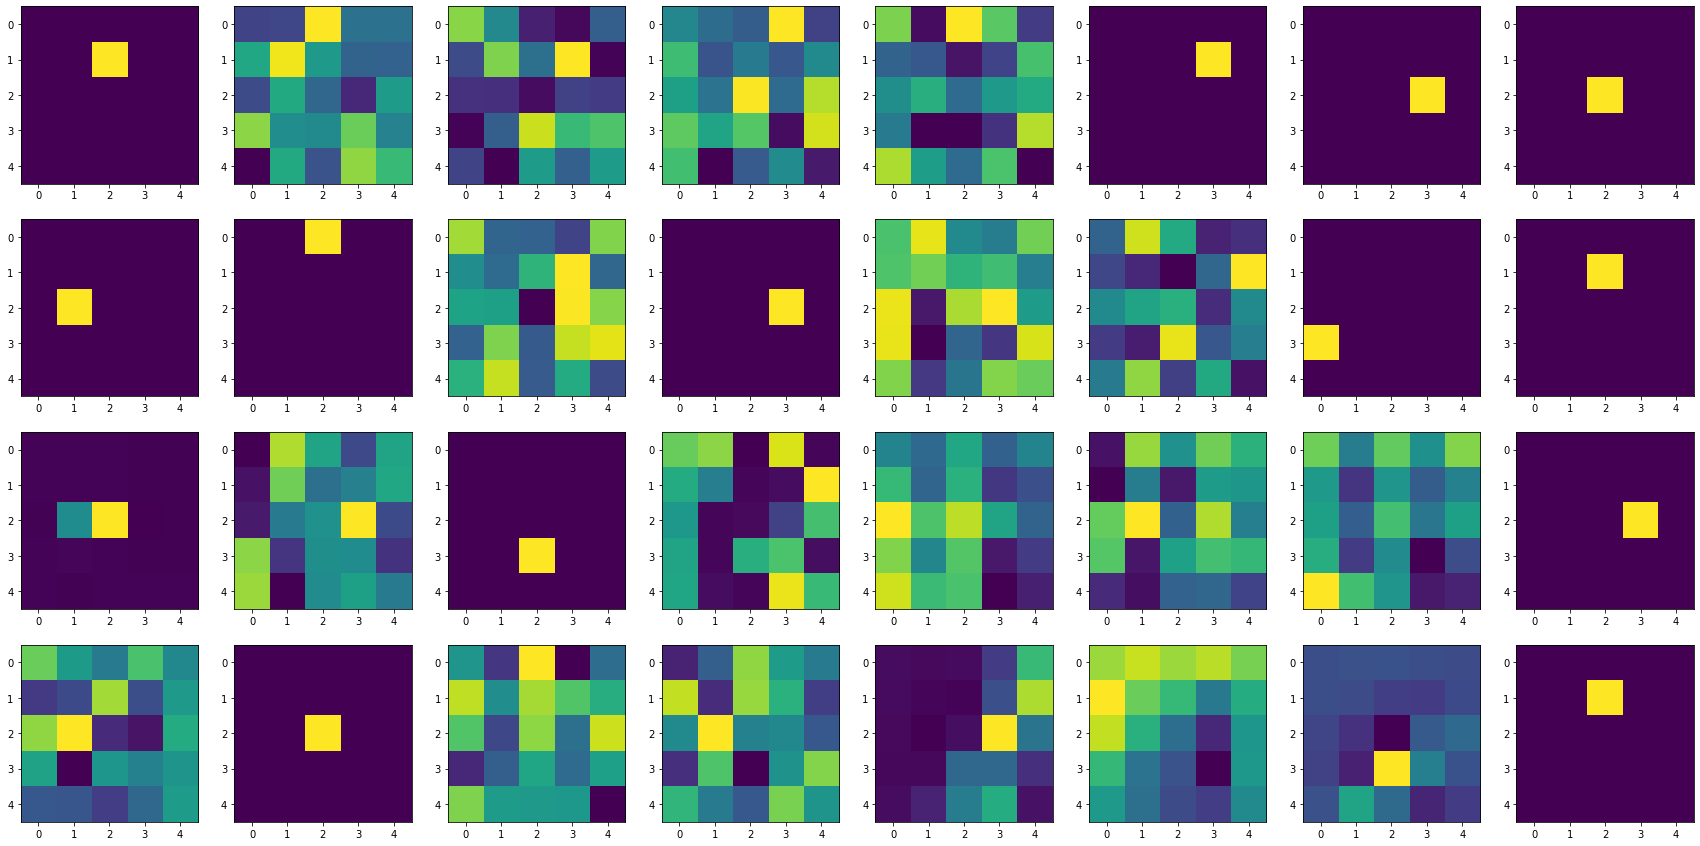

In [20]:
# Visualize conv filter of Conv1
kernels = adv_model_linf.conv1.weight.detach()
fig, axarr = plt.subplots(4,8,figsize=(30,15))
idx=0
for i in range(4):
    for j in range(8):
        axarr[i,j].imshow(kernels[idx].squeeze())
        idx+=1

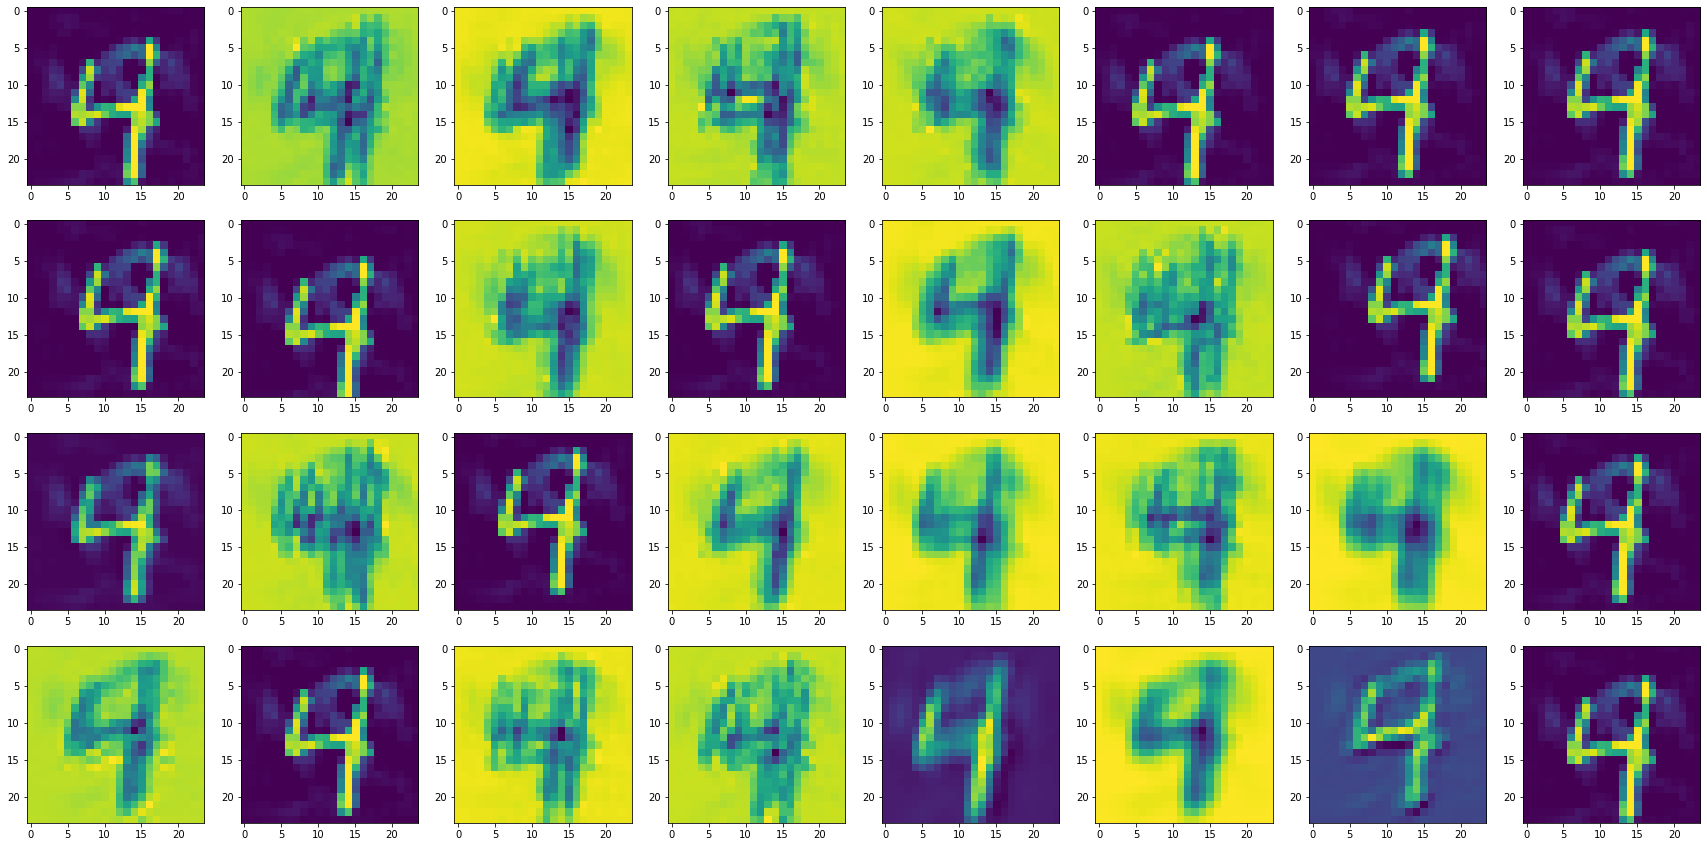

In [21]:
# Visualize feature maps PGD Data
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

adv_model_linf.conv1.register_forward_hook(get_activation('conv1'))

x,y = val[19]
x=x.unsqueeze(0).to(DEVICE)
y=torch.tensor(y)
y = y.unsqueeze(0).to(DEVICE)
x_adv_l2 = pgd(model, x, y, torch.nn.CrossEntropyLoss(), k=120, step=0.1, eps=1.7, norm=2)

output = adv_model_linf(x_adv_l2) 

adv_act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(4,8,figsize=(30,15))
idx=0
for i in range(4):
    for j in range(8):
        axarr[i,j].imshow(adv_act[idx])
        idx+=1

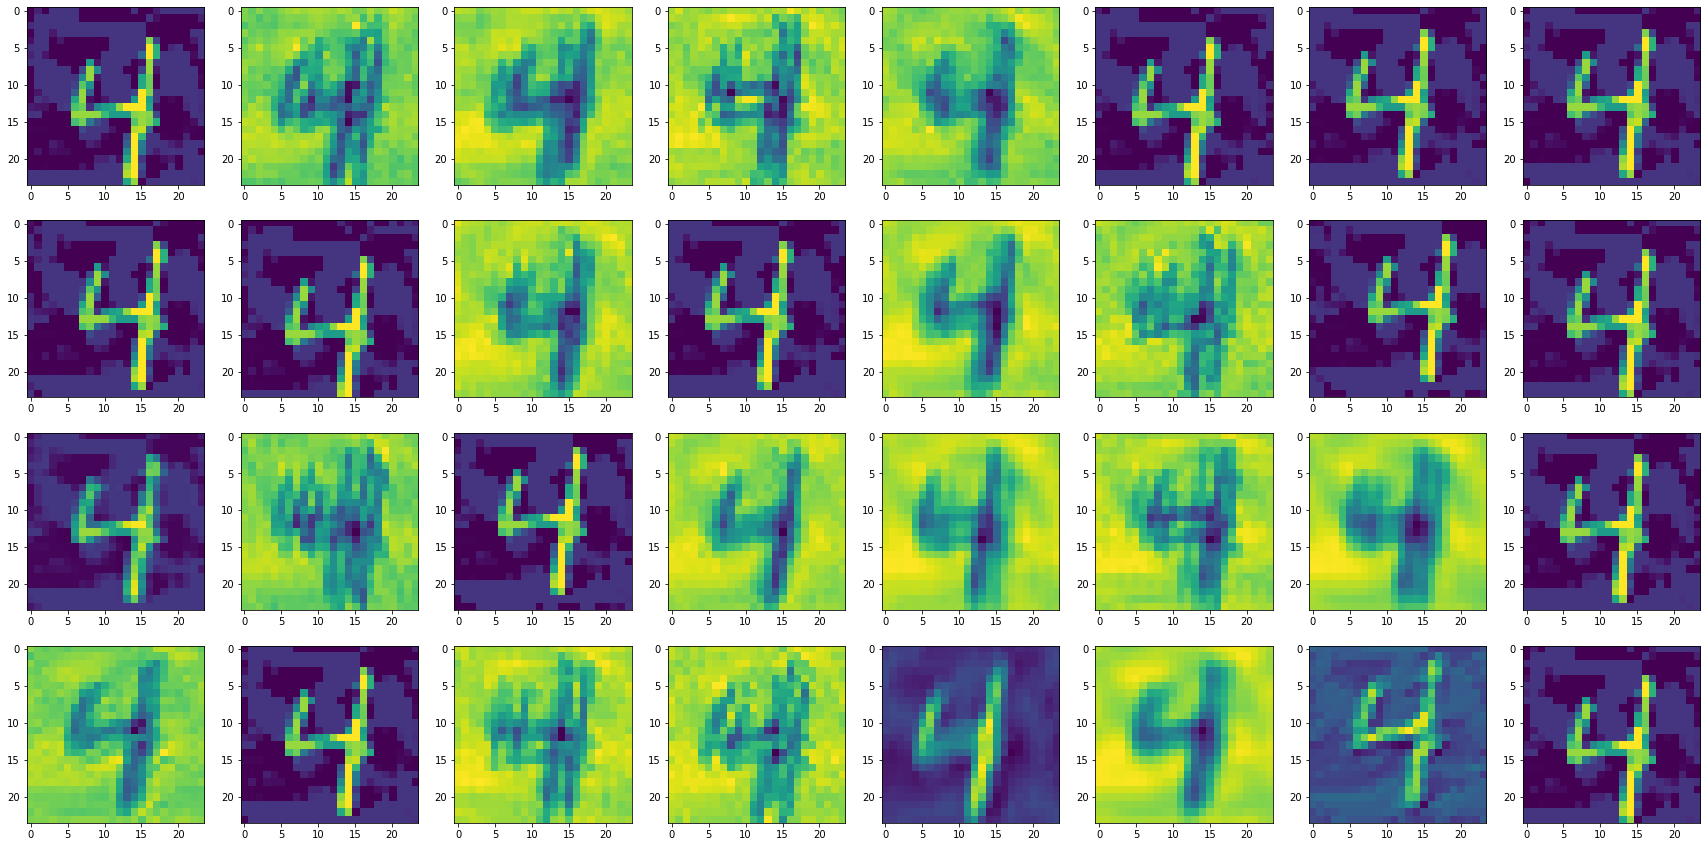

In [22]:
# Visualize feature maps FGSM Data
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

adv_model_linf.conv1.register_forward_hook(get_activation('conv1'))

x,y = val[19]
x=x.unsqueeze(0).to(DEVICE)
y=torch.tensor(y)
y = y.unsqueeze(0).to(DEVICE)
x_adv_linf = iterated_fgsm(model, x, y, torch.nn.CrossEntropyLoss(), k=60, step=0.01, eps=0.15, norm='inf')
output = adv_model_linf(x_adv_linf) 

adv_act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(4,8,figsize=(30,15))
idx=0
for i in range(4):
    for j in range(8):
        axarr[i,j].imshow(adv_act[idx])
        idx+=1



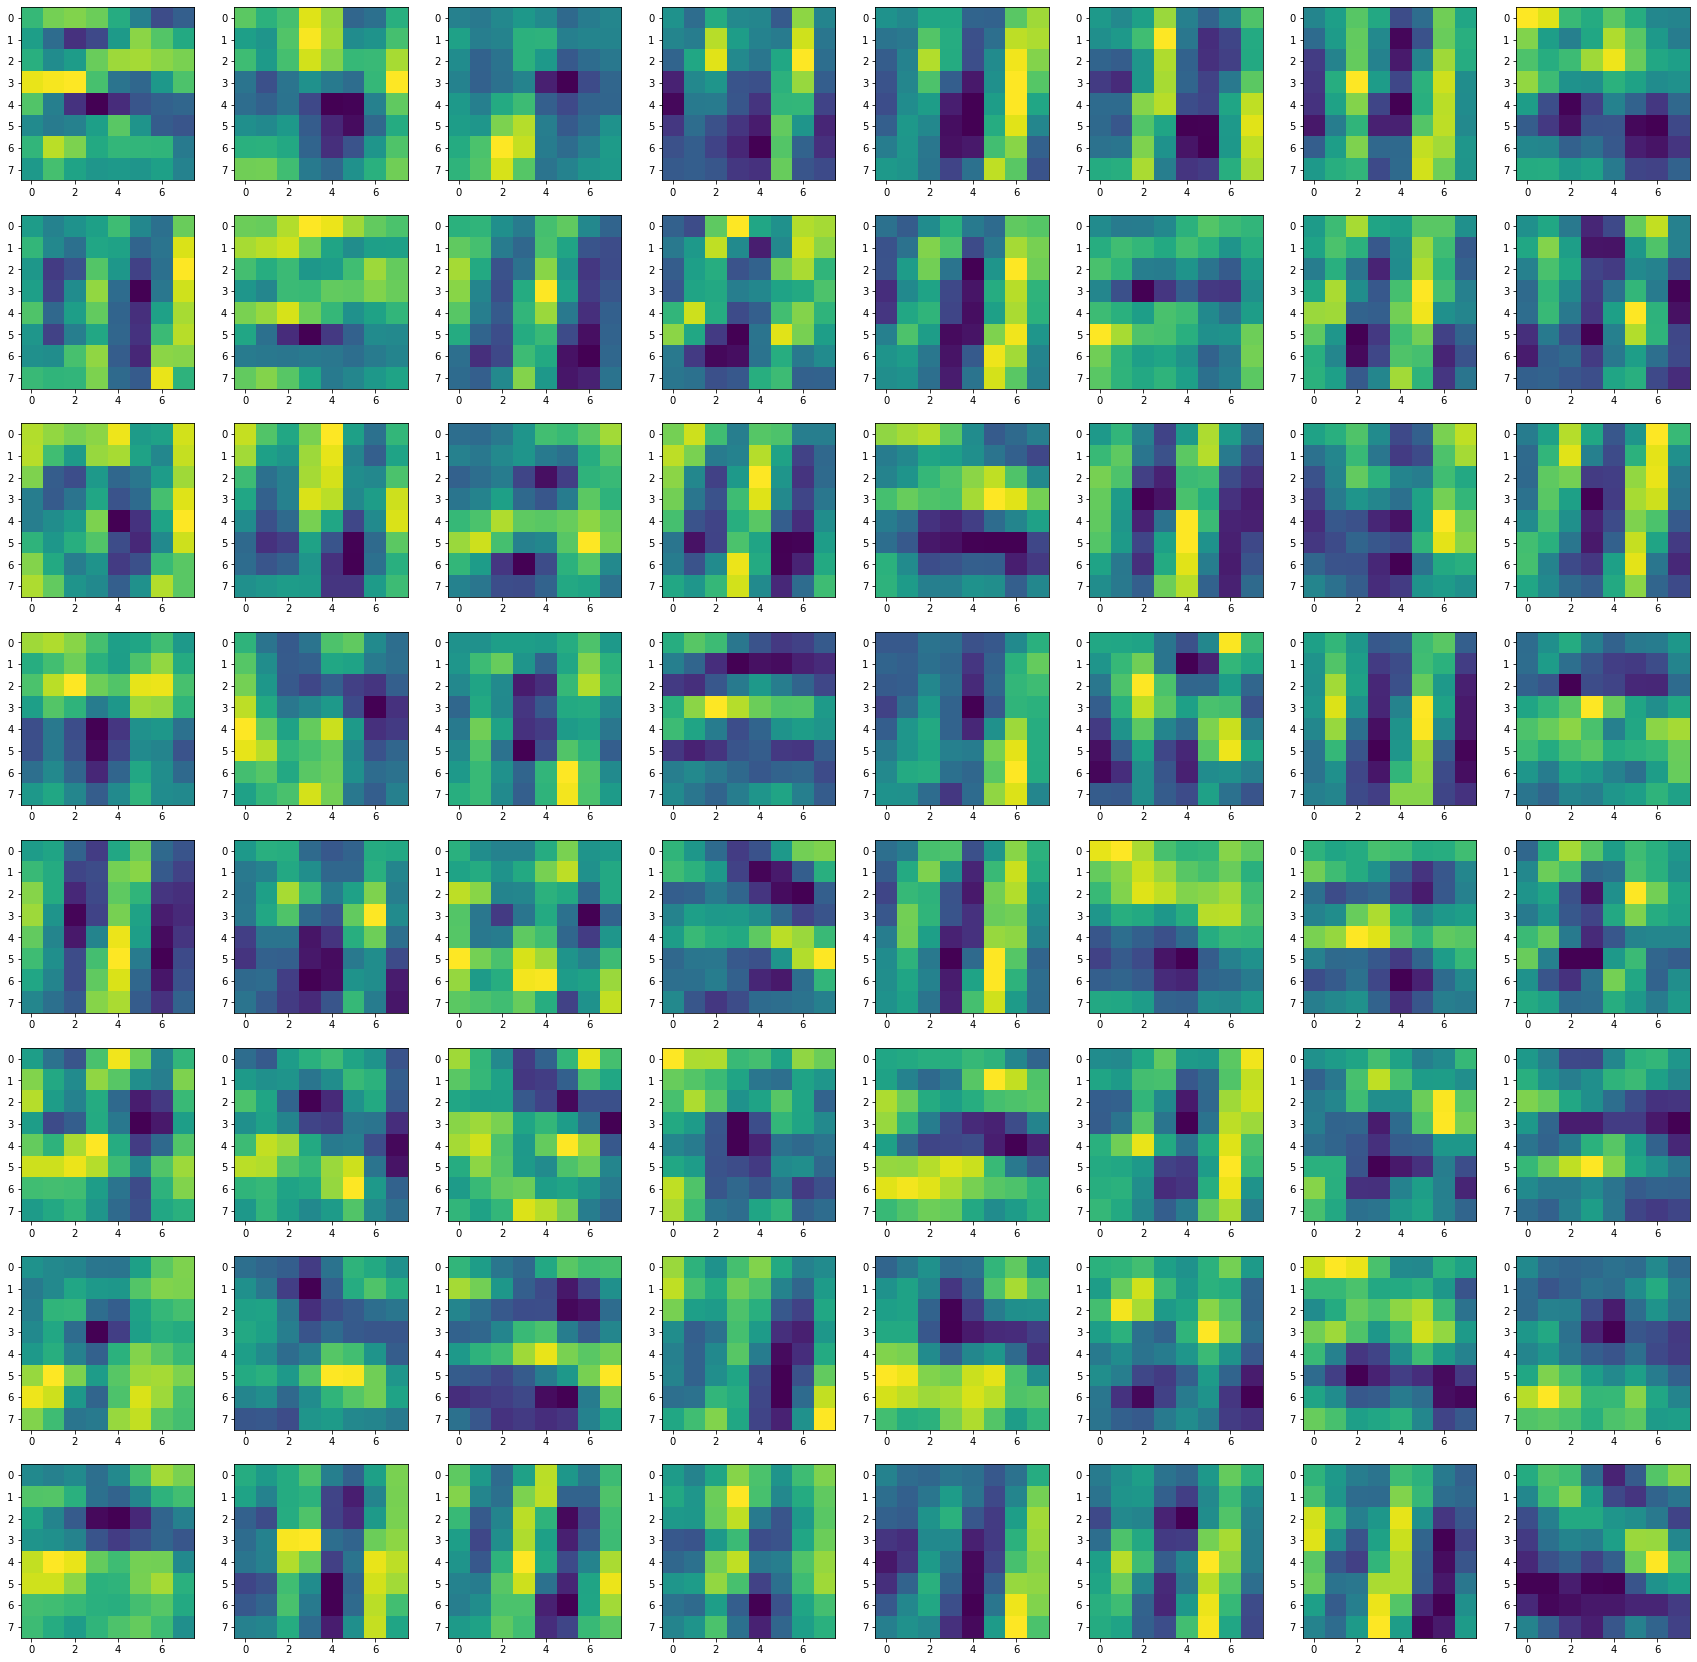

In [27]:
# Visualize feature maps of FGSM sample through 2nd conv layer in non robust model
activation_adv = {}
def get_activation(name):
    def hook(model, input, output):
        activation_adv[name] = output.detach()
    return hook

adv_model_linf.conv2.register_forward_hook(get_activation('conv2'))

x,y = val[19]
x=x.unsqueeze(0).to(DEVICE)
y=torch.tensor(y)
y = y.unsqueeze(0).to(DEVICE)
x_adv_linf = iterated_fgsm(model, x, y, torch.nn.CrossEntropyLoss(), k=60, step=0.01, eps=0.15, norm='inf')
output = model(x_adv_linf) 

act_adv = activation_adv['conv2'].squeeze()
fig, axarr = plt.subplots(8,8,figsize=(30,30))
idx=0


for i in range(8):
    for j in range(8):
        axarr[i,j].imshow(act_adv[idx])
        idx+=1